# Evaluation Script For Network Related Plots and Values

In [4]:
# energy intensity kWh/GB
ENERGY_INTENSITY_NETWORK_KWH_PER_GB = 0.0037

In [5]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
import importlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from os import listdir, path
from IPython.display import display, Markdown
import math
from scipy.interpolate import interp1d



import os
import sys

# if current working directory includes "evaluation" change to parent directory
if "evaluation" in os.getcwd():
    os.chdir("..")
    # Add parent directory to sys.path
    sys.path.append(os.getcwd())



# Verify
print(f"Current working directory: {os.getcwd()}")
print(f"sys.path: {sys.path}")

Current working directory: /root/oxn
sys.path: ['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/root/oxn/venv/lib/python3.11/site-packages', '/root/oxn']


# Short Setup Tests

In [6]:
# Import report
from gevent import monkey
monkey.patch_all()
import evaluation.evaluation as evaluation


importlib.reload(evaluation)

from evaluation.evaluation import Report

assert os.path.exists("reports"), "No reports directory found. Please run the experiments first."


yaml_files = sorted(
    (f for f in os.listdir("reports") if f.lower().endswith(".yaml")),
    key=lambda fn: os.path.getmtime(path.join("reports", fn))
)

if not yaml_files:
    raise RuntimeError("No .yaml reports found in reports/")

# sort them by date
yaml_files.sort(key=lambda x: path.getctime(path.join("reports",x)))
yaml_files = yaml_files[::-1]

# Load the last experiment
last_experiment = yaml_files[0]

report_path = path.join("reports", last_experiment)
report = Report.from_file(report_path)
print(f"Loaded report {last_experiment}")

assert report is not [], "No report found. Please run the experiments first."
assert isinstance(report, Report), "Report is not of type Report"


assert report.interactions is not [], "No interactions found."
assert report.interactions[0] is not [], "No interactions found. "
assert report.interactions[0].response_data is not [], "No data in interaction found"


Loaded report report_2025-07-17_05-30-26.yaml


In [7]:
# invert the files_in_direcotry list 
#files_in_direcotory = files_in_direcotory[::-1]

experiments_map = {
    "recommendation_k8_base_1m_otel_persistence": None,
    "recommendation_k8_base_5_percent_persistence": None,
    "recommendation_k8_base_10_percent_persistence": None,
    "recommendation_k8_base_50_percent_persistence": None,
    "recommendation_k8_base_1m_otel_persistence_istio": None,
    "recommendation_k8_base_1m_otel_persistence_scrape_5s": None,
    "recommendation_k8_base_1m_otel_persistence_scrape_30s": None,
}


# iterate over all reports and find a string in them
print("Searching for most recent experiments in list of reports " + len(yaml_files).__str__())
for file in yaml_files:
    report_path = path.join("reports", file)
    # read the file as a string
    with open(report_path, "r") as f:
        content = f.read()
        # iterate over all experiments and check if the string contains the experiment name
        
        for experiment in experiments_map.keys():
            if f"{experiment}.yml" in content:
                if experiments_map[experiment]:
                    print(f"Found {experiment} in {file} but already found in {experiments_map[experiment]}. Did the recent run not included all experiments?")
                    continue
                experiments_map[experiment] = file
                print(f"Found {experiment} in {file}")
                break
    
    if all(experiments_map.values()):
        print("All experiments found")
        break
        

Searching for most recent experiments in list of reports 21
Found recommendation_k8_base_1m_otel_persistence_istio in report_2025-07-17_05-30-26.yaml
Found recommendation_k8_base_50_percent_persistence in report_2025-07-17_04-15-12.yaml
Found recommendation_k8_base_10_percent_persistence in report_2025-07-17_03-00-32.yaml
Found recommendation_k8_base_5_percent_persistence in report_2025-07-17_01-45-27.yaml
Found recommendation_k8_base_1m_otel_persistence_scrape_30s in report_2025-07-17_00-30-49.yaml
Found recommendation_k8_base_1m_otel_persistence_scrape_5s in report_2025-07-16_23-16-11.yaml
Found recommendation_k8_base_1m_otel_persistence in report_2025-07-16_22-01-34.yaml
All experiments found


In [8]:
# Patch all and reload evaluation module
monkey.patch_all()
importlib.reload(evaluation)

# cache the dataframes
cached_dataframes_network_pods = []
cached_dataframes_network_namespace = []

Loading some basic functions used later on

In [9]:

# Function to load a report and extract specific interactions
def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        print(f"Found {len(selected_interactions)} interactions for {report_name} and {treatment_name}.")
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None      
        
def load_reports_and_normalize_time(cached_dataframes, report_directory, response_name, treatment_names, report_names):
    response_dataframes = cached_dataframes or []
    # Load the interactions if not already loaded
    if not response_dataframes or len(response_dataframes) == 0:
        print(f"Loading dataframes from reports because cached dataframes are empty.")
        for report_name in report_names:
            for treatment_name in treatment_names:
                interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
                if interaction:
                    assert interaction.response_data is not None, "No data in interaction found."
                    print(interaction)
                    print(interaction.response_data)
                    # Add columns to identify the treatment and report
                    interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                    interaction.response_data["treatment_start"] = interaction.treatment_start
                    interaction.response_data["treatment_end"] = interaction.treatment_end
                    interaction.response_data["label"] = f"{REPORT_LABELS[report_name]}"

                    response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    else:
        print("Using cached dataframes.")
    cached_dataframes = response_dataframes

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        assert isinstance(response_dataframes, list)

        for df in response_dataframes:
            assert isinstance(df, pd.DataFrame)
            # Convert index to datetime if needed and ensure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Ensure both are timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Calculate the interval between data points in seconds
            time_interval = (df.index[1] - df.index[0]).total_seconds()

            # Add the experiment_seconds column
            df = df.copy()  # Work with a copy to avoid modifying a view
            df.loc[:, "experiment_seconds"] = (df.index - current_treatment_start).total_seconds()
            df.loc[:, "time_normalized"] = df["experiment_seconds"]

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)
    else:
        print("No valid interactions found for the specified treatment names.")


    # Combine all the normalized dataframes
    combined_df = pd.concat(normalized_dataframes)
    return cached_dataframes, combined_df, treatment_start_time, treatment_end_time
   
def plot_network_metrics_per_pod_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time):
    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    print(combined_df)
    # Get unique container names
    container_names = combined_df["label_app_kubernetes_io_name"].unique()

    # Determine the grid size for subplots
    num_containers = len(container_names)
    num_cols = 2  # Define the number of columns for the grid
    num_rows = math.ceil(num_containers / num_cols)

    # Set the style for seaborn
    sns.set(style="whitegrid")
    sns.set_palette("pastel")

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

    # hue is the list of all unique treatments
    hue = combined_df["treatment"].unique()
    
    # use a lowpass filter to smooth the data
    combined_df[response_name] = combined_df[response_name].rolling(window=6, center=True, min_periods=2).mean()
   
        

    # Plot the data for each container_name in a subplot
    for idx, container_name in enumerate(container_names):
        ax = axes[idx]
        container_df = combined_df[combined_df["label_app_kubernetes_io_name"] == container_name]
        # Interpolate the data for smoothing
        for treatment, df in container_df.groupby("treatment"):
            if len(df) > 1:
                # if there is an  error in interp1d then just skip this one
                try:
                    f = interp1d(df["experiment_seconds"], df[response_name], kind='cubic')
                except:
                    continue 
                experiment_seconds_new = np.linspace(df["experiment_seconds"].min(), df["experiment_seconds"].max(), num=500)
                response_interpolated = f(experiment_seconds_new)
                sns.lineplot(
                    x=experiment_seconds_new,
                    y=response_interpolated,
                    ax=ax,
                    label=f"{df['label'].iloc[0]}",
                    linewidth=2
                )
            else:
                print(f"Only one data point for {container_name} in treatment {treatment}.")
                """ sns.lineplot(
                    data=df,
                    x="experiment_seconds",
                    y=response_name,
                    ax=ax,
                    label=f"{treatment}",
                    palette="tab10",
                    linewidth=2
                ) """

        # Add vertical lines for treatment start and end times (normalized)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

        ax.set_title(f"Container: {container_name}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel("Bytes received per [time unit missing]")
        ax.set_xlim(-500, treatment_end_seconds + 500)
        ax.legend()

    # Hide any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_individual_and_aggregated(combined_df, response_name, treatment_end_time, treatment_start_time, container_key="label_app_kubernetes_io_name", interpolation_kind="cubic", rolling_window=6):
    """
    Plots individual treatment curves (with smoothing and interpolation) along with the aggregated mean and standard deviation.
    
    Parameters:
        combined_df (DataFrame): The DataFrame containing experiment data.
        response_name (str): Column name to be used for the y-axis (e.g. metric to plot).
        treatment_end_time (datetime): End time of the treatment.
        treatment_start_time (datetime): Start time of the treatment.
        container_key (str): Column name that identifies the container (default is "label_app_kubernetes_io_name").
    """
    # Normalize treatment times (t0 is set to 0)
    treatment_start_seconds = 0  
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    # Compute aggregated statistics by rounding experiment_seconds
    combined_df['rounded_experiment_seconds'] = combined_df['experiment_seconds'].round(0)
    agg_df = (
        combined_df
        .groupby([container_key, 'rounded_experiment_seconds'])[response_name]
        .agg(['mean', 'std'])
        .reset_index()
    )
    
    # Get unique container names and determine grid dimensions for subplots
    container_names = combined_df[container_key].unique()
    num_containers = len(container_names)
    num_cols = 2
    num_rows = math.ceil(num_containers / num_cols)
    
    # Set the seaborn style and palette for consistency
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    # Create subplots for each container
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten() if num_containers > 1 else [axes]
    
    # Smooth the response data using a rolling window
    combined_df[response_name] = combined_df[response_name].rolling(window=rolling_window, center=True, min_periods=2).mean()
    
    # Loop through each container and plot both individual and aggregated results
    for idx, container in enumerate(container_names):
        ax = axes[idx]
        container_df = combined_df[combined_df[container_key] == container]
        
        # Plot individual treatment curves
        for treatment, df in container_df.groupby("treatment"):
            if len(df) > 1:
                # Interpolate using cubic spline
                f = interp1d(df["experiment_seconds"], df[response_name], kind=interpolation_kind)
                experiment_seconds_new = np.linspace(df["experiment_seconds"].min(), df["experiment_seconds"].max(), num=500)
                response_interpolated = f(experiment_seconds_new)
                sns.lineplot(
                    x=experiment_seconds_new,
                    y=response_interpolated,
                    ax=ax,
                    label=f"{df['label'].iloc[0]}",
                    linewidth=2
                )
            else:
                print(f"Only one data point for container '{container}' in treatment '{treatment}'.")
        
        # Plot aggregated mean with markers
        container_agg = agg_df[agg_df[container_key] == container]
        sns.lineplot(
            x='rounded_experiment_seconds',
            y='mean',
            data=container_agg,
            marker='o',
            ax=ax,
            label='Mean'
        )
        # Fill the area between mean - std and mean + std
        ax.fill_between(
            container_agg['rounded_experiment_seconds'],
            container_agg['mean'] - container_agg['std'],
            container_agg['mean'] + container_agg['std'],
            alpha=0.3,
            label='STD'
        )
        
        # Add vertical lines for treatment start (t0) and end (t1)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")
        
        ax.set_title(f"Container: {container}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel(response_name)
        ax.set_xlim(-500, treatment_end_seconds + 500)
        ax.grid(True)
        ax.legend()
    
    # Remove any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()


def plot_percentage_uncertainty(combined_df, response_name, treatment_end_time, treatment_start_time, container_key="label_app_kubernetes_io_name", rolling_window=6):
    """
    Plots the percentage uncertainty (calculated as std/mean * 100) for aggregated treatment data.
    
    Parameters:
        combined_df (DataFrame): The DataFrame containing experiment data.
        response_name (str): Column name of the metric to use for calculations.
        treatment_end_time (datetime): End time of the treatment.
        treatment_start_time (datetime): Start time of the treatment.
        container_key (str): Column name that identifies the container (default is "label_app_kubernetes_io_name").
        rolling_window (int): Window size for smoothing the response data.
    """
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Normalize treatment times (t0 is set to 0)
    treatment_start_seconds = 0  
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    # Smooth the response data using a rolling window
    combined_df[response_name] = combined_df[response_name].rolling(window=rolling_window, center=True, min_periods=2).mean()
    
    # Round experiment_seconds for aggregation
    combined_df['rounded_experiment_seconds'] = combined_df['experiment_seconds'].round(0)
    
    # Compute aggregated statistics: mean and std for each container and time point
    agg_df = (
        combined_df
        .groupby([container_key, 'rounded_experiment_seconds'])[response_name]
        .agg(['mean', 'std'])
        .reset_index()
    )
    
    # Compute percentage uncertainty (avoid division by zero)
    agg_df['uncertainty_pct'] = np.where(agg_df['mean'] != 0, (agg_df['std'] / agg_df['mean']) * 100, 0)
    
    # Get unique container names and determine grid dimensions for subplots
    container_names = combined_df[container_key].unique()
    num_containers = len(container_names)
    num_cols = 2
    num_rows = math.ceil(num_containers / num_cols)
    
    # Set the seaborn style and palette for consistency
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    # Create subplots for each container
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten() if num_containers > 1 else [axes]
    
    # Loop through each container and plot the percentage uncertainty
    for idx, container in enumerate(container_names):
        ax = axes[idx]
        container_agg = agg_df[agg_df[container_key] == container]
        
        sns.lineplot(
            x='rounded_experiment_seconds',
            y='uncertainty_pct',
            data=container_agg,
            marker='o',
            ax=ax,
            label='Uncertainty (%)'
        )
        
        # Add vertical lines for treatment start (t0) and end (t1)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")
        
        ax.set_title(f"Container: {container}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel("Uncertainty (%)")
        ax.set_xlim(-500, treatment_end_seconds + 500)
        ax.grid(True)
        ax.legend()
    
    # Remove any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()


## Network Trafic Energy Consumption

In [10]:
report_directory = "reports/"
treatment_names = ["delay_treatment", "empty_treatment"]

In [11]:

#                       baseline                                    5% base                                                10% base                                                      50% base                                            1s
#                       baseline                                    5% base                                                10% base                                                      50% base                                            1s
report_names = [ experiments_map["recommendation_k8_base_1m_otel_persistence"], experiments_map["recommendation_k8_base_5_percent_persistence"], experiments_map["recommendation_k8_base_10_percent_persistence"], experiments_map["recommendation_k8_base_50_percent_persistence"], experiments_map["recommendation_k8_base_1m_otel_persistence_istio"], experiments_map["recommendation_k8_base_1m_otel_persistence_scrape_5s"], experiments_map["recommendation_k8_base_1m_otel_persistence_scrape_30s"]]
REPORT_LABELS = {report_names[0]: "Base Persistence", report_names[1]: "5% Persistence", report_names[2]: "10% Persistence", report_names[3]: "50% Persistence", report_names[4]: "Persistence Istio",  report_names[5]: "Scrape 5s Persistence", report_names[6]: "Scrape 30s Persistence"}

response_name = "cadvisor_network_bytes_received_all"


#report_base_network_namespace = load_report_interactions(report_directory, report_names[0], response_name, "empty_treatment")
#report_sampling_5_percent_network_namespace = load_report_interactions(report_directory, report_names[1], response_name, "empty_treatment")
#report_base_10_percent_network_namespace = load_report_interactions(report_directory, report_names[2], response_name, "empty_treatment")
#report_base_50_percent_network_namespace = load_report_interactions(report_directory, report_names[3], response_name, "empty_treatment")
#report_base_1s_network_namespace = load_report_interactions(report_directory, report_names[4], response_name, "empty_treatment")
#report_base_0_percent_network_namespace = load_report_interactions(report_directory, report_names[5], response_name, "empty_treatment")
#report_base_persistence_network_namespace = load_report_interactions(report_directory, report_names[6], response_name, "empty_treatment")
#report_base_5_percent_persistence_network_namespace = load_report_interactions(report_directory, report_names[7], response_name, "empty_treatment")
#report_base_10_percent_persistence_network_namespace = load_report_interactions(report_directory, report_names[8], response_name, "empty_treatment")
#report_base_50_percent_persistence_network_namespace = load_report_interactions(report_directory, report_names[9], response_name, "empty_treatment")

#report_base_persistence_istio_network_namespace = load_report_interactions(report_directory, report_names[10], response_name, "empty_treatment")

Loading dataframes from reports because cached dataframes are empty.
[Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesPrometheusIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesPrometheusIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesPrometheusIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment,

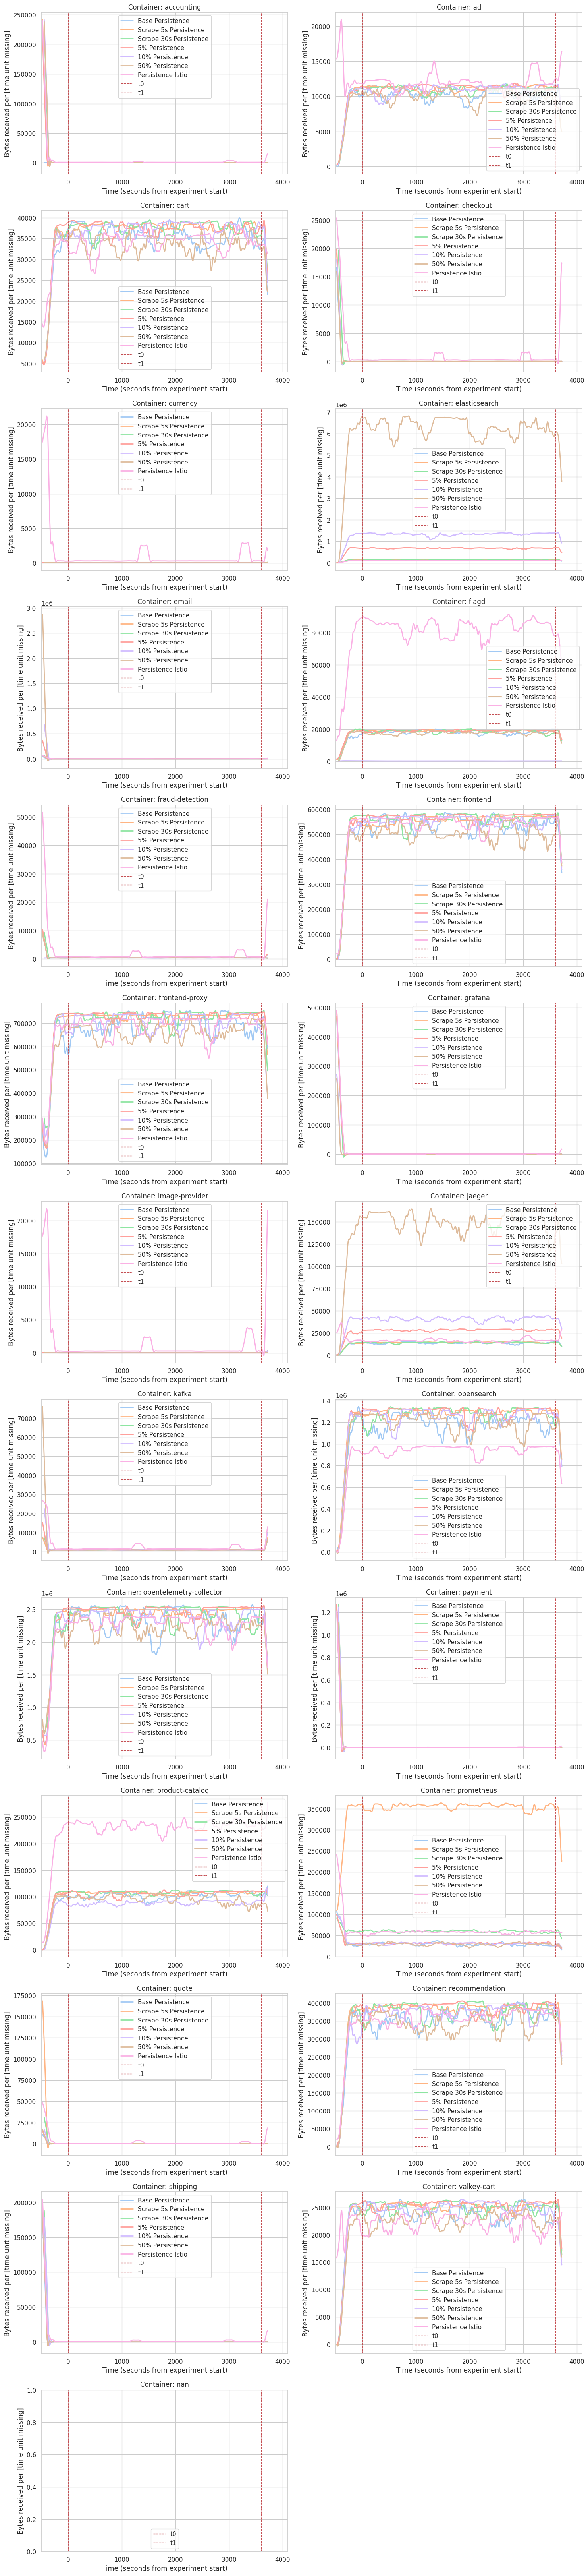

In [13]:

cached_dataframes_network_pods, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_dataframes_network_pods, report_directory, response_name, treatment_names, report_names)

plot_network_metrics_per_pod_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time)

In [22]:


def get_network_energy_consumption(interaction, treatment_name):
    treatment_start_end_values = {}
    
    number_of_containers = len(interaction.response_data["label_app_kubernetes_io_name"].unique())
    #print(f"Interaction: {interaction.treatment_name} with {number_of_containers} containers")
    # Assuming `interaction.response_data` is your dataframe
    for container_name, df in interaction.response_data.groupby("label_app_kubernetes_io_name"):
        
        #print(f"Container: {container_name} - Treatment: {treatment_name}")
        # Filter for rows where treatment is "Treatment"
        #treatment_df = df[df[treatment_name] == treatment_name]



        print(f"Container: {container_name} - Treatment: {treatment_name} - Rows: {len(df)}")
        
        if df[treatment_name] is None or df[treatment_name].isnull().all():
            print(f"Container: {container_name}, found interaction without the correct 'Treatment' period found.")
            continue

        # cut off the first and last 10% of the data
        treatment_df = df.iloc[int(len(df) * 0.1):int(len(df) * 0.9)]

        print(f"Container: {container_name} - Treatment: {treatment_name} - Rows: {len(treatment_df)}")

        #print(treatment_df)
    
        
        if not treatment_df.empty:
            # TODO: use increase() in prometheus query instead of fixing it here
            # the values are normally monotonic increasing, but there are some exceptions where the values resets to 0 and starts again
            # so we have to check if each following value is greater than the previous one and if not, then we have to add the difference
            
            # Extract the column into a separate series to avoid chained assignment
            column = treatment_df["cadvisor_network_bytes_received_all_absolute"].copy()

            # Iterate through the series to fix monotonicity
            for i in range(1, len(column)):
                if column.iloc[i] < column.iloc[i - 1]:
                    print(f"Container: {container_name}, Found break in monotonicity at index {i}. Fixing it.")
                    # Calculate the difference and propagate it to all subsequent values
                    difference = column.iloc[i - 1] - column.iloc[i]
                    column.iloc[i:] += difference

            # Assign the fixed series back to the DataFrame
            treatment_df["cadvisor_network_bytes_received_all_absolute"] = column

           # get the first and last value of the treatment
            treatment_start = treatment_df["cadvisor_network_bytes_received_all_absolute"].iloc[0]
            treatment_end = treatment_df["cadvisor_network_bytes_received_all_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            # calc the time difference in seconds between the first and last value
            time_difference = (treatment_df.index[-1] - treatment_df.index[0]).total_seconds()
            
            
            treatment_start_end_values[container_name] = (treatment_start, treatment_end, difference, time_difference)
            
            #print(f"Container: {container_name}, Treatment start: {treatment_start}, Treatment end: {treatment_end}")
            #print(f"Difference: {difference}")
            if difference < 0:
                print(f"Container: {container_name}, Negative difference found.")
        else:
            print(f"Container: {container_name}, No 'Treatment' period found.")

    return treatment_start_end_values

treatment_start_end = {}

cached_dataframes_network_pods = []
cached_dataframes_network_namespace = []

report_base_network_namespace = load_report_interactions(report_directory, report_names[0], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_sampling_5_percent_network_namespace = load_report_interactions(report_directory, report_names[1], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_base_10_percent_network_namespace = load_report_interactions(report_directory, report_names[2], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_base_50_percent_network_namespace = load_report_interactions(report_directory, report_names[3], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_base_1s_network_namespace = load_report_interactions(report_directory, report_names[4], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_base_0_percent_network_namespace = load_report_interactions(report_directory, report_names[5], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_base_persistence_network_namespace = load_report_interactions(report_directory, report_names[6], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_base_5_percent_persistence_network_namespace = load_report_interactions(report_directory, report_names[7], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_base_10_percent_persistence_network_namespace = load_report_interactions(report_directory, report_names[8], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")
report_base_50_percent_persistence_network_namespace = load_report_interactions(report_directory, report_names[9], "cadvisor_network_bytes_received_all_absolute", "empty_treatment")

report_base_network_namespace_values = get_network_energy_consumption(report_base_network_namespace, "empty_treatment")
report_sampling_5_percent_storage_namespace_values = get_network_energy_consumption(report_sampling_5_percent_network_namespace, "empty_treatment")
report_base_10_percent_network_namespace_values = get_network_energy_consumption(report_base_10_percent_network_namespace, "empty_treatment")
report_base_50_percent_network_namespace_values = get_network_energy_consumption(report_base_50_percent_network_namespace, "empty_treatment")
report_base_1s_network_namespace_values = get_network_energy_consumption(report_base_1s_network_namespace, "empty_treatment")
report_base_0_percent_network_namespace_values = get_network_energy_consumption(report_base_0_percent_network_namespace, "empty_treatment")
report_base_persistence_network_namespace_values = get_network_energy_consumption(report_base_persistence_network_namespace, "empty_treatment")
report_base_5_percent_persistence_network_namespace_values = get_network_energy_consumption(report_base_5_percent_persistence_network_namespace, "empty_treatment")
report_base_10_percent_persistence_network_namespace_values = get_network_energy_consumption(report_base_10_percent_persistence_network_namespace, "empty_treatment")
report_base_50_percent_persistence_network_namespace_values = get_network_energy_consumption(report_base_50_percent_persistence_network_namespace, "empty_treatment")

# merge base and base persistence for the loop because we want to loop over all containers but they are not necessarily the same in both reports
container_names = set(report_base_network_namespace_values.keys()).union(
    report_sampling_5_percent_storage_namespace_values.keys(),
    report_base_10_percent_network_namespace_values.keys(),
    report_base_50_percent_network_namespace_values.keys(),
    report_base_1s_network_namespace_values.keys(),
    report_base_0_percent_network_namespace_values.keys(),
    report_base_persistence_network_namespace_values.keys(),
    report_base_5_percent_persistence_network_namespace_values.keys(),
    report_base_10_percent_persistence_network_namespace_values.keys(),
    report_base_50_percent_persistence_network_namespace_values.keys()
)
container_names = sorted(container_names)

for container_namespace in container_names:
    print(f"Container: {container_namespace}")
    if container_namespace in report_sampling_5_percent_storage_namespace_values:
        percentage_differece_sampling = (report_sampling_5_percent_storage_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for sampling 5%: {percentage_differece_sampling:.2f}%")
    else:
        percentage_differece_sampling = None
        print(f"Container: {container_namespace} - No data for sampling 5%")

    if container_namespace in report_base_10_percent_network_namespace_values:
        percentage_differece_base_10_percent = (report_base_10_percent_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for base 10%: {percentage_differece_base_10_percent:.2f}%")
    else:
        percentage_differece_base_10_percent = None
        print(f"Container: {container_namespace} - No data for base 10%")

    if container_namespace in report_base_50_percent_network_namespace_values:
        percentage_differece_base_50_percent = (report_base_50_percent_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for base 50%: {percentage_differece_base_50_percent:.2f}%")
    else:
        percentage_differece_base_50_percent = None
        print(f"Container: {container_namespace} - No data for base 50%")

    if container_namespace in report_base_1s_network_namespace_values:
        percentage_differece_base_1s = (report_base_1s_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for base 1s: {percentage_differece_base_1s:.2f}%")
    else:
        percentage_differece_base_1s = None
        print(f"Container: {container_namespace} - No data for base 1s")

    if container_namespace in report_base_0_percent_network_namespace_values:
        percentage_difference_base_0_percent = (report_base_0_percent_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for base 0%: {percentage_difference_base_0_percent:.2f}%")
    else:
        percentage_difference_base_0_percent = None
        print(f"Container: {container_namespace} - No data for base 0%")

    print("-----------------------------------------------")
    """
    if container_namespace in report_base_persistence_network_namespace_values:
        percentage_difference_base_persistence = (report_base_persistence_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for base persistence: {percentage_difference_base_persistence:.2f}%")
    else:
        percentage_difference_base_persistence = None
        print(f"Container: {container_namespace} - No data for base persistence")
    
     
    if container_namespace in report_base_5_percent_persistence_network_namespace_values:
        percentage_difference_base_5_percent_persistence = (report_base_5_percent_persistence_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for base 5% persistence: {percentage_difference_base_5_percent_persistence:.2f}%")
    else:
        percentage_difference_base_5_percent_persistence = None
        print(f"Container: {container_namespace} - No data for base 5% persistence")

    if container_namespace in report_base_10_percent_persistence_network_namespace_values:
        percentage_difference_base_10_percent_persistence = (report_base_10_percent_persistence_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for base 10% persistence: {percentage_difference_base_10_percent_persistence:.2f}%")
    else:
        percentage_difference_base_10_percent_persistence = None
        print(f"Container: {container_namespace} - No data for base 10% persistence")

    if container_namespace in report_base_50_percent_persistence_network_namespace_values:
        percentage_difference_base_50_percent_persistence = (report_base_50_percent_persistence_network_namespace_values[container_namespace][2] - report_base_network_namespace_values[container_namespace][2]) / report_base_network_namespace_values[container_namespace][2] * 100
        print(f"Container: {container_namespace} - Percentage difference for base 50% persistence: {percentage_difference_base_50_percent_persistence:.2f}%")
    else:
        percentage_difference_base_50_percent_persistence = None
        print(f"Container: {container_namespace} - No data for base 50% persistence")
    """
    
    
   
    
sum_base = sum([report_base_network_namespace_values[container_namespace][2] for container_namespace in report_base_network_namespace_values])
sum_sampling_5_percent = sum([report_sampling_5_percent_storage_namespace_values[container_namespace][2] for container_namespace in report_sampling_5_percent_storage_namespace_values])
sum_base_10_percent = sum([report_base_10_percent_network_namespace_values[container_namespace][2] for container_namespace in report_base_10_percent_network_namespace_values])
sum_base_50_percent = sum([report_base_50_percent_network_namespace_values[container_namespace][2] for container_namespace in report_base_50_percent_network_namespace_values])
sum_base_1s = sum([report_base_1s_network_namespace_values[container_namespace][2] for container_namespace in report_base_1s_network_namespace_values])

percentage_differece_sampling = (sum_sampling_5_percent - sum_base) / sum_base * 100
percentage_differece_base_10_percent = (sum_base_10_percent - sum_base) / sum_base * 100
percentage_differece_base_50_percent = (sum_base_50_percent - sum_base) / sum_base * 100
percentage_differece_base_1s = (sum_base_1s - sum_base) / sum_base * 100

print(f"Namespace: system-under-evaluation")
print(f"Base Treatment: {sum_base} in {report_base_network_namespace_values[container_namespace][3]}s")
print(f"Base 1s Treatment: {sum_base_1s} ({percentage_differece_base_1s:.2f}%) in {report_base_1s_network_namespace_values[container_namespace][3]}s")
print(f"Sampling 5% Treatment: {sum_sampling_5_percent} ({percentage_differece_sampling:.2f}%) in {report_sampling_5_percent_storage_namespace_values[container_namespace][3]}s")
print(f"Base 10% Treatment: {sum_base_10_percent} ({percentage_differece_base_10_percent:.2f}%) in {report_base_10_percent_network_namespace_values[container_namespace][3]}s")
print(f"Base 50% Treatment: {sum_base_50_percent} ({percentage_differece_base_50_percent:.2f}%) in {report_base_50_percent_network_namespace_values[container_namespace][3]}s")


# calc median, average and percentlies of all containers
base_values = [report_base_network_namespace_values[container_namespace][2] for container_namespace in report_base_network_namespace_values]
sampling_5_percent_values = [report_sampling_5_percent_storage_namespace_values[container_namespace][2] for container_namespace in report_sampling_5_percent_storage_namespace_values]
base_10_percent_values = [report_base_10_percent_network_namespace_values[container_namespace][2] for container_namespace in report_base_10_percent_network_namespace_values]
base_50_percent_values = [report_base_50_percent_network_namespace_values[container_namespace][2] for container_namespace in report_base_50_percent_network_namespace_values]
base_1s_values = [report_base_1s_network_namespace_values[container_namespace][2] for container_namespace in report_base_1s_network_namespace_values]

print(f"Base Treatment: Median: {np.median(base_values)}, Mean: {np.mean(base_values)}, 90th Percentile: {np.percentile(base_values, 90)}")
print(f"Sampling 5% Treatment: Median: {np.median(sampling_5_percent_values)}, Mean: {np.mean(sampling_5_percent_values)}, 90th Percentile: {np.percentile(sampling_5_percent_values, 90)}")
print(f"Base 10% Treatment: Median: {np.median(base_10_percent_values)}, Mean: {np.mean(base_10_percent_values)}, 90th Percentile: {np.percentile(base_10_percent_values, 90)}")
print(f"Base 50% Treatment: Median: {np.median(base_50_percent_values)}, Mean: {np.mean(base_50_percent_values)}, 90th Percentile: {np.percentile(base_50_percent_values, 90)}")
print(f"Base 1s Treatment: Median: {np.median(base_1s_values)}, Mean: {np.mean(base_1s_values)}, 90th Percentile: {np.percentile(base_1s_values, 90)}")


print("-----------------------------------------------")

energy_intensity = 0.0037 # kWh/GB
# calculate the energy consumption in kWh
energy_base = (sum_base/1000/1000/1000) * energy_intensity
energy_base_1s = (sum_base_1s/1000/1000/1000) * energy_intensity
energy_10_percent = (sum_base_10_percent/1000/1000/1000) * energy_intensity
energy_50_percent = (sum_base_50_percent/1000/1000/1000) * energy_intensity

print(f"Base Treatment: {energy_base} kWh")
print(f"Base 1s Treatment: {energy_base_1s} kWh")
print(f"Base 10% Treatment: {energy_10_percent} kWh")
print(f"Base 50% Treatment: {energy_50_percent} kWh")



[Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=Metr

/tmp/ipykernel_1490057/2244212059.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["cadvisor_network_bytes_received_all_absolute"] = column
/tmp/ipykernel_1490057/2244212059.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["cadvisor_network_bytes_received_all_absolute"] = column
/tmp/ipykernel_1490057/2244212059.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [25]:
# Directory containing reports
report_directory = "reports"

report_base = load_report_interactions(report_directory, report_names[0], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_sampling_5_percent = load_report_interactions(report_directory, report_names[1], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_base_10_percent = load_report_interactions(report_directory, report_names[2], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_base_50_percent = load_report_interactions(report_directory, report_names[3], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_base_1s = load_report_interactions(report_directory, report_names[4], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_base_0_percent = load_report_interactions(report_directory, report_names[5], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_base_persistence = load_report_interactions(report_directory, report_names[6], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_base_5_percent_persistence = load_report_interactions(report_directory, report_names[7], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_base_10_percent_persistence = load_report_interactions(report_directory, report_names[8], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")
report_base_50_percent_persistence = load_report_interactions(report_directory, report_names[9], "cadvisor_network_bytes_received_combined_absolute", "empty_treatment")


[Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=Metr

In [30]:
def get_network_energy_consumption(interaction, treatment_name):
    treatment_start_end_values = {}
    for container_namespace, df in interaction.response_data.groupby("namespace"):
        # only consider the values when the treatment is present
        #treatment_df = df[df[treatment_name] == treatment_name]

        treatment_df = df

        if not treatment_df.empty:
            # get the first and last value of the treatment
            treatment_start = treatment_df["cadvisor_network_bytes_received_combined_absolute"].iloc[0]
            treatment_end = treatment_df["cadvisor_network_bytes_received_combined_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            difference_time = (treatment_df.index[-1] - treatment_df.index[0]).total_seconds()
            
            
            treatment_start_end_values[container_namespace] = (treatment_start, treatment_end, difference, difference_time)
    return treatment_start_end_values

treatment_start_end = {}

values_base_network_namespace = get_network_energy_consumption(report_base, "empty_treatment")
values_sampling_5_percent_network_namespace = get_network_energy_consumption(report_sampling_5_percent, "empty_treatment")
values_base_10_percent_network_namespace = get_network_energy_consumption(report_base_10_percent, "empty_treatment")
values_base_50_percent_network_namespace = get_network_energy_consumption(report_base_50_percent, "empty_treatment")
values_base_1s_network_namespace = get_network_energy_consumption(report_base_1s, "empty_treatment")
values_base_0_percent_network_namespace = get_network_energy_consumption(report_base_0_percent, "empty_treatment")
values_base_persistence_network_namespace = get_network_energy_consumption(report_base_persistence, "empty_treatment")
values_base_5_percent_persistence_network_namespace = get_network_energy_consumption(report_base_5_percent_persistence, "empty_treatment")
values_base_10_percent_persistence_network_namespace = get_network_energy_consumption(report_base_10_percent_persistence, "empty_treatment")
values_base_50_percent_persistence_network_namespace = get_network_energy_consumption(report_base_50_percent_persistence, "empty_treatment")

for container_namespace, values in values_base_network_namespace.items():
    percentage_differece_sampling = (values_sampling_5_percent_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    percentage_differece_base_10_percent = (values_base_10_percent_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    percentage_differece_base_50_percent = (values_base_50_percent_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    percentage_differece_base_1s = (values_base_1s_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    percentage_difference_base_0_percent = (values_base_0_percent_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    percentage_difference_base_persistence = (values_base_persistence_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    percentage_difference_base_5_percent_persistence = (values_base_5_percent_persistence_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    percentage_difference_base_10_percent_persistence = (values_base_10_percent_persistence_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    percentage_difference_base_50_percent_persistence = (values_base_50_percent_persistence_network_namespace[container_namespace][2] - values_base_network_namespace[container_namespace][2]) / values_base_network_namespace[container_namespace][2] * 100
    
    print(f"Namespace: {container_namespace}")
    print(f"Base Treatment: {values_base_network_namespace[container_namespace][2]} in {values_base_network_namespace[container_namespace][3]}s")
    print(f"Sampling 5% Treatment: {values_sampling_5_percent_network_namespace[container_namespace][2]} ({percentage_differece_sampling:.2f}%) in {values_sampling_5_percent_network_namespace[container_namespace][3]}s")
    print(f"Base 10% Treatment: {values_base_10_percent_network_namespace[container_namespace][2]} ({percentage_differece_base_10_percent:.2f}%) in {values_base_10_percent_network_namespace[container_namespace][3]}s")
    print(f"Base 50% Treatment: {values_base_50_percent_network_namespace[container_namespace][2]} ({percentage_differece_base_50_percent:.2f}%) in {values_base_50_percent_network_namespace[container_namespace][3]}s")
    print(f"Base 1s Treatment: {values_base_1s_network_namespace[container_namespace][2]} ({percentage_differece_base_1s:.2f}%) in {values_base_1s_network_namespace[container_namespace][3]}s")
    print(f"Base 0% Treatment: {values_base_0_percent_network_namespace[container_namespace][2]} ({percentage_difference_base_0_percent:.2f}%) in {values_base_0_percent_network_namespace[container_namespace][3]}s")
    print(f"Base Persistence Treatment: {values_base_persistence_network_namespace[container_namespace][2]} ({percentage_difference_base_persistence:.2f}%) in {values_base_persistence_network_namespace[container_namespace][3]}s")
    print(f"Base 5% Persistence Treatment: {values_base_5_percent_persistence_network_namespace[container_namespace][2]} ({percentage_difference_base_5_percent_persistence:.2f}%) in {values_base_5_percent_persistence_network_namespace[container_namespace][3]}s")
    print(f"Base 10% Persistence Treatment: {values_base_10_percent_persistence_network_namespace[container_namespace][2]} ({percentage_difference_base_10_percent_persistence:.2f}%) in {values_base_10_percent_persistence_network_namespace[container_namespace][3]}s")
    print(f"Base 50% Persistence Treatment: {values_base_50_percent_persistence_network_namespace[container_namespace][2]} ({percentage_difference_base_50_percent_persistence:.2f}%) in {values_base_50_percent_persistence_network_namespace[container_namespace][3]}s")
    print("-----------------------------------------------")
    print(f"Energy Consumption in kWh:")
    energy_base = (values_base_network_namespace[container_namespace][2] / 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    energy_base_1s = (values_base_1s_network_namespace[container_namespace][2]/ 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    energy_10_percent = (values_base_10_percent_network_namespace[container_namespace][2] / 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    energy_50_percent = (values_base_50_percent_network_namespace[container_namespace][2] / 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    energy_0_percent = (values_base_0_percent_network_namespace[container_namespace][2] / 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    energy_persistence = (values_base_persistence_network_namespace[container_namespace][2] / 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    energy_5_percent_persistence = (values_base_5_percent_persistence_network_namespace[container_namespace][2] / 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    energy_10_percent_persistence = (values_base_10_percent_persistence_network_namespace[container_namespace][2] / 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    energy_50_percent_persistence = (values_base_50_percent_persistence_network_namespace[container_namespace][2] / 1000 / 1000 / 1000) * 0.0037  # kWh/GB
    print(f"Base Treatment: {energy_base:.4f} kWh ({percentage_differece_sampling:.2f}%)")
    print(f"Base 1s Treatment: {energy_base_1s:.4f} kWh ({percentage_differece_base_1s:.2f}%)")
    print(f"Base 10% Treatment: {energy_10_percent:.4f} kWh ({percentage_differece_base_10_percent:.2f}%)")
    print(f"Base 50% Treatment: {energy_50_percent:.4f} kWh ({percentage_differece_base_50_percent:.2f}%)")
    print(f"Base 0% Treatment: {energy_0_percent:.4f} kWh ({percentage_difference_base_0_percent:.2f}%)")
    print(f"Base Persistence Treatment: {energy_persistence:.4f} kWh ({percentage_difference_base_persistence:.2f}%)")
    print(f"Base 5% Persistence Treatment:  {energy_5_percent_persistence:.4f} kWh ({percentage_difference_base_5_percent_persistence:.2f}%)")
    print(f"Base 10% Persistence Treatment: {energy_10_percent_persistence:.4f} kWh ({percentage_difference_base_10_percent_persistence:.2f}%)")
    print(f"Base 50% Persistence Treatment: {energy_50_percent_persistence:.4f} kWh ({percentage_difference_base_50_percent_persistence:.2f}%)")
    print("-----------------------------------------------")    
    




Namespace: system-under-evaluation
Base Treatment: 21197517412 in 1680.0s
Sampling 5% Treatment: 19990873354 (-5.69%) in 1710.0s
Base 10% Treatment: 21146213037 (-0.24%) in 1680.0s
Base 50% Treatment: 21790155671 (2.80%) in 1710.0s
Base 1s Treatment: 21331936371 (0.63%) in 1680.0s
Base 0% Treatment: 21440416389 (1.15%) in 1680.0s
Base Persistence Treatment: 21541155666 (1.62%) in 1710.0s
Base 5% Persistence Treatment: 23303470833 (9.93%) in 1680.0s
Base 10% Persistence Treatment: 25774333777 (21.59%) in 1710.0s
Base 50% Persistence Treatment: 34803600456 (64.19%) in 1680.0s
-----------------------------------------------
Energy Consumption in kWh:
Base Treatment: 0.0784 kWh (-5.69%)
Base 1s Treatment: 0.0789 kWh (0.63%)
Base 10% Treatment: 0.0782 kWh (-0.24%)
Base 50% Treatment: 0.0806 kWh (2.80%)
Base 0% Treatment: 0.0793 kWh (1.15%)
Base Persistence Treatment: 0.0797 kWh (1.62%)
Base 5% Persistence Treatment:  0.0862 kWh (9.93%)
Base 10% Persistence Treatment: 0.0954 kWh (21.59%)
Bas

                         Baseline       1s       5%      10%      50%
accounting                   1.21     1.22     1.24     1.20     1.22
ad                          30.31    30.76    29.22    30.99    31.07
cart                       102.56   105.56    98.77   105.17   105.88
checkout                     0.08     0.08     0.08     0.08     0.08
currency                     0.02     0.02     0.00     0.00     0.00
email                        0.00     0.00     0.00     0.00     0.00
flagd                       50.99    52.90    48.57    53.38    53.74
fraud-detection              1.00     1.00     1.02     1.00     1.02
frontend                  1551.15  1560.83  1462.38  1566.53  1584.25
frontend-proxy            2005.37  1980.34  1897.38  2000.87  1983.73
grafana                      0.28     0.28     0.28     0.27     0.27
image-provider               0.02     0.02     0.00     0.00     0.00
jaeger                      33.00    32.64    63.62    98.97   374.41
kafka               

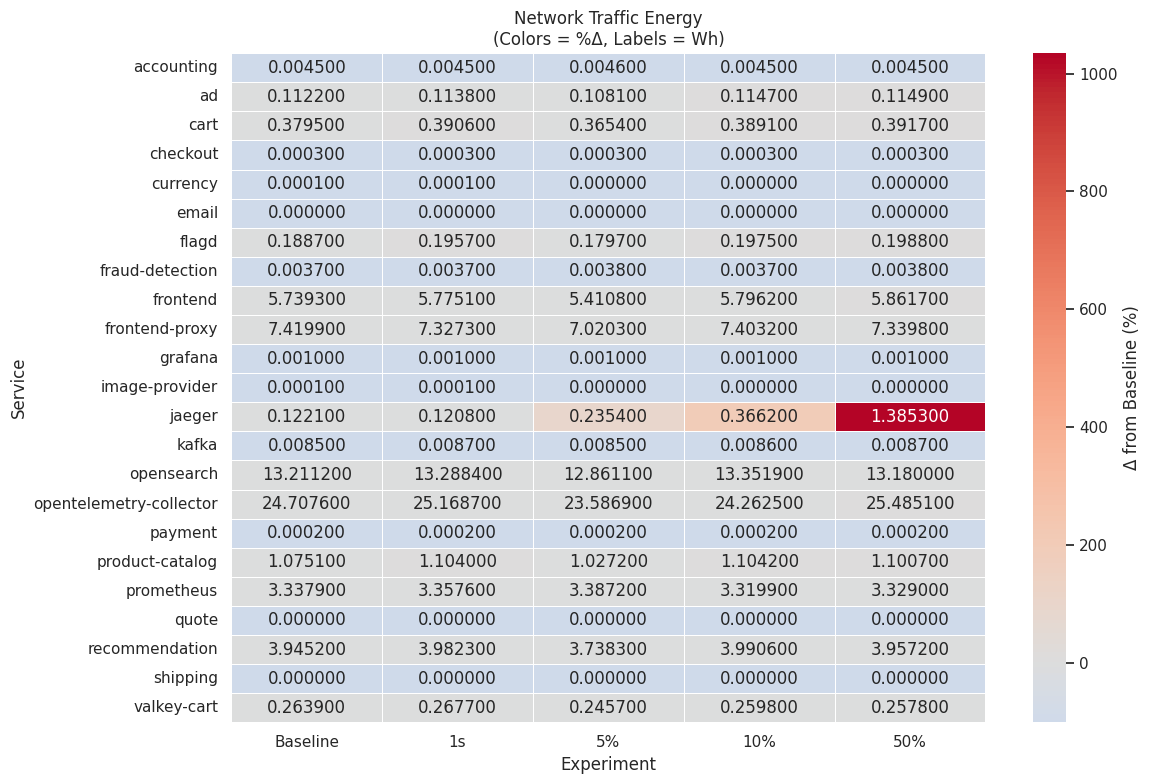

                         Baseline Persistence  5% Pers.  10% Pers.  50% Pers.
accounting                               1.22      1.21       1.25       1.23
ad                                      31.28     29.65      29.82      28.48
cart                                   103.10     99.85     100.32      92.59
checkout                                 0.08      0.08       0.08       0.08
currency                                 0.02      0.00       0.00       0.00
elasticsearch                          733.40   2550.38    4650.08   13155.50
email                                    0.00      0.00       0.00       0.00
flagd                                   50.65     51.37      49.21      48.06
fraud-detection                          1.00      1.00       1.01       1.00
frontend                              1501.33   1503.59    1467.91    1418.02
frontend-proxy                        1971.47   1887.44    1904.81    1820.30
grafana                                  0.28      0.27       0.

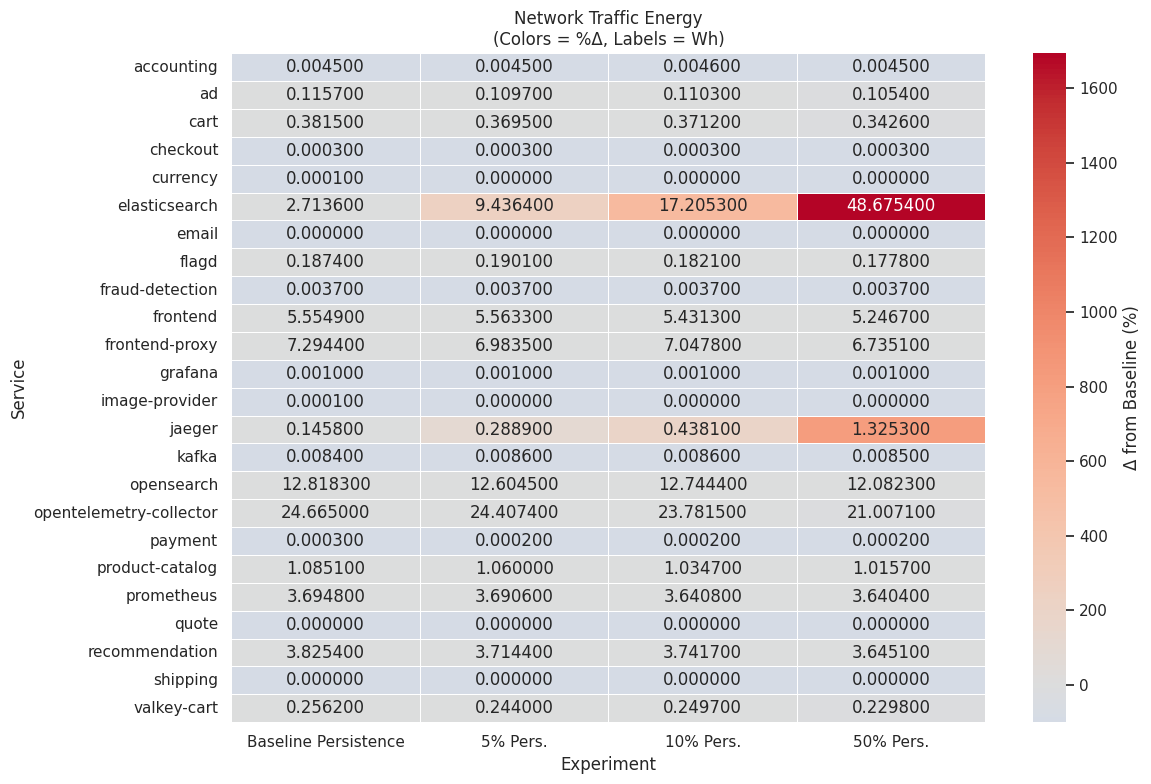

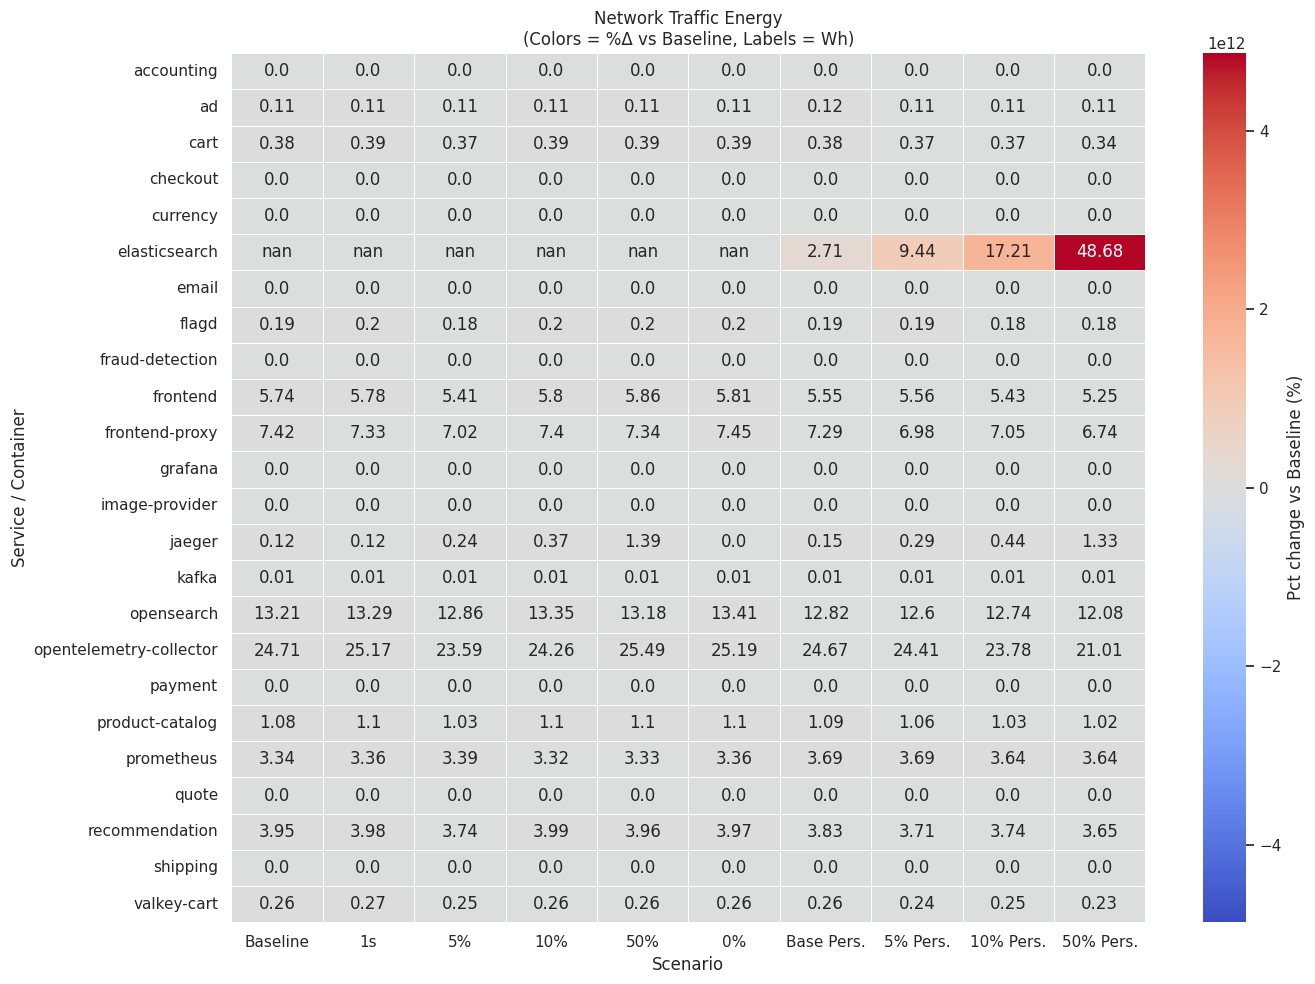

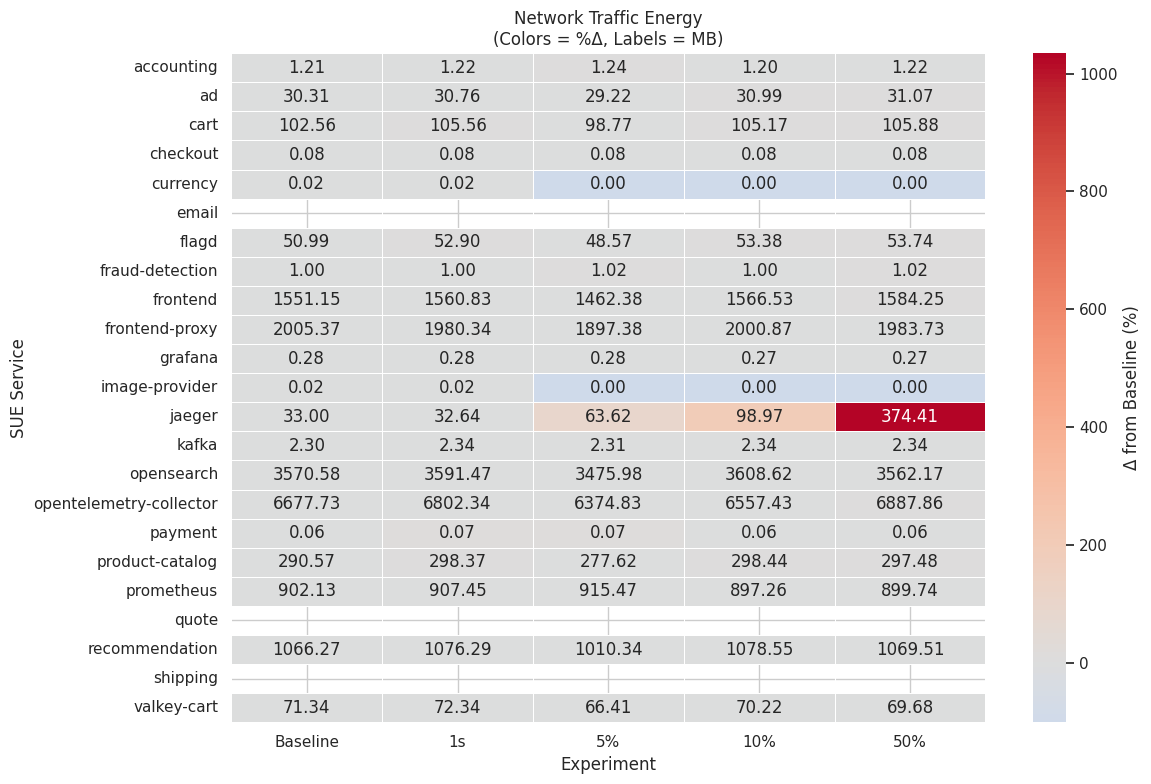

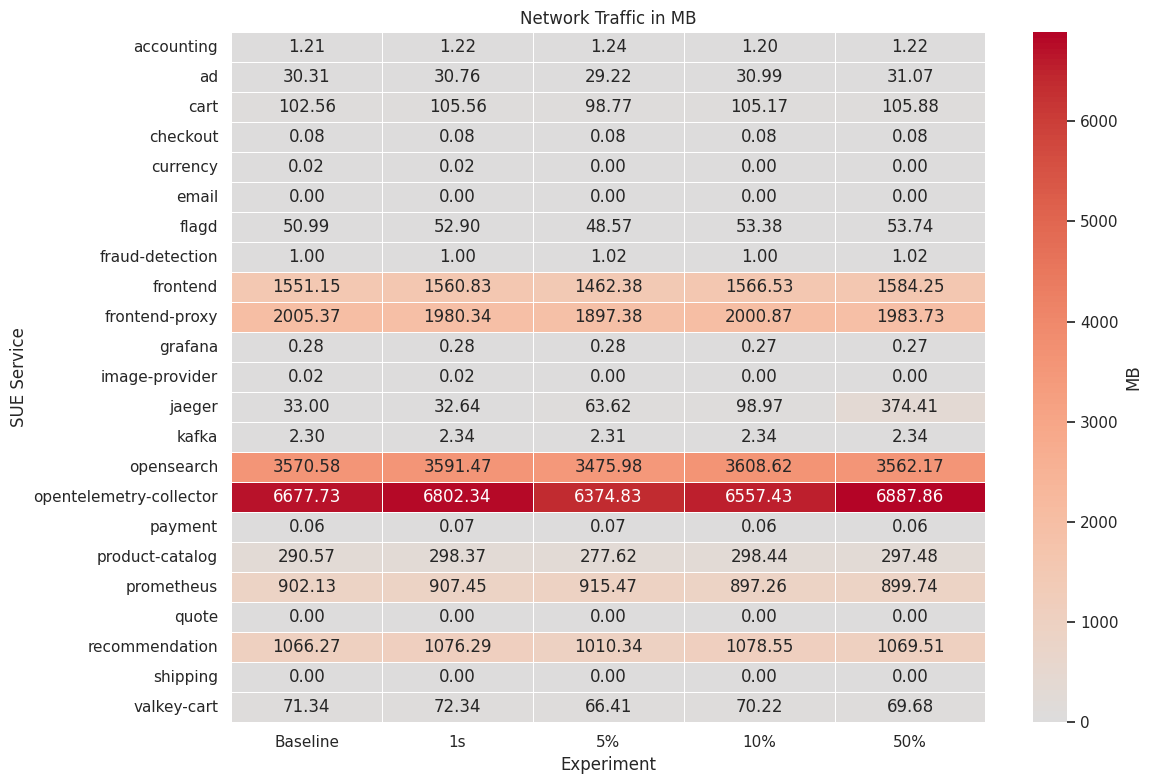

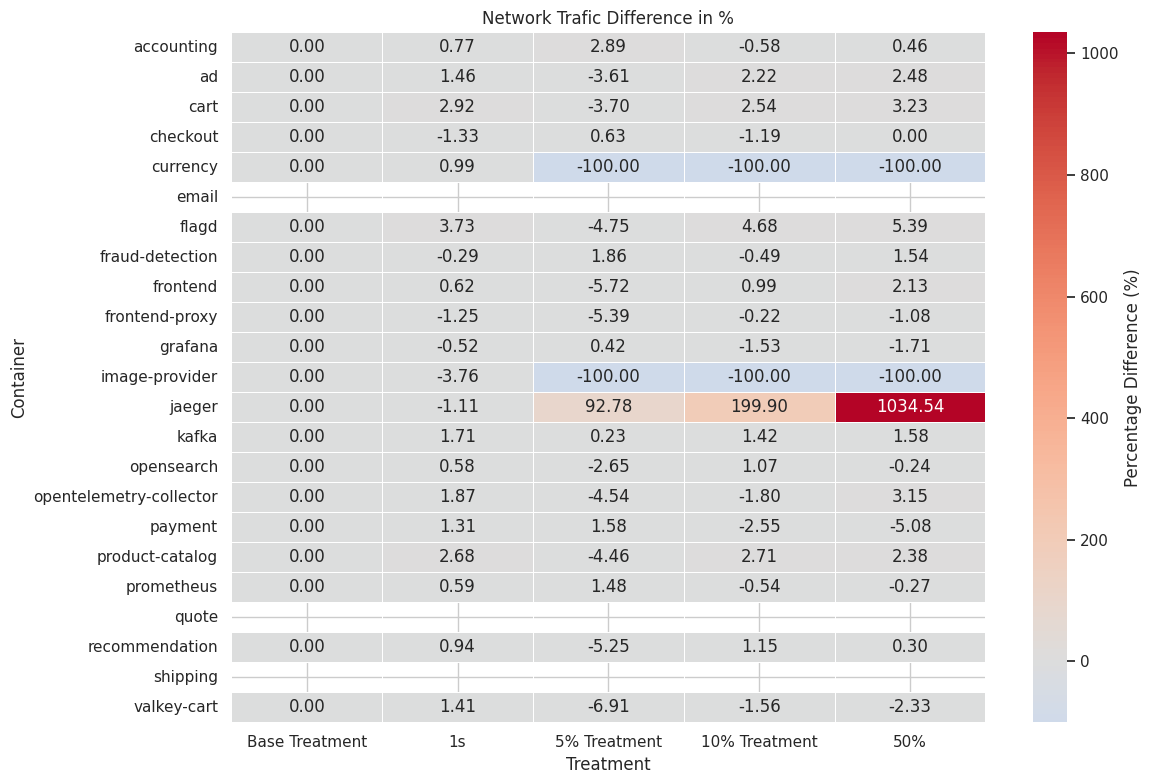

In [33]:
def generate_difference_matrix_percentage(
        treatment_start_end_base, 
        treatment_start_end_base_1s,
        treatment_start_end_5percent, 
        treatment_start_end_base_10percent,
        treatment_start_end_base_50percent,
        ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers],
        #"Delay Treatment": [treatment_start_end_delay[c][2] for c in containers],
        "1s": [treatment_start_end_base_1s[c][2] for c in containers],
        #"Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers],
        #"5% Delay Treatment": [treatment_start_end_delay_5percent[c][2] for c in containers],
        "10% Treatment": [treatment_start_end_base_10percent[c][2] for c in containers],
        #"10% Delay Treatment": [treatment_start_end_delay_10percent[c][2] for c in containers],
        "50%": [treatment_start_end_base_50percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in data.keys():
        percentage_difference[col] = (df[col] - df["Base Treatment"]) / df["Base Treatment"] * 100

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Network Trafic Difference in %")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()
    
def generate_difference_matrix(
        treatment_start_end_base,
        treatment_start_end_base_1s,
        treatment_start_end_5percent,
        treatment_start_end_base_10percent,
        treatment_start_end_base_50percent,
        ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        #"Delay": [treatment_start_end_delay[c][2] for c in containers],
        "1s": [treatment_start_end_base_1s[c][2] for c in containers],
        #"Delay 1s": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5%": [treatment_start_end_5percent[c][2] for c in containers],
        #"5% Delay": [treatment_start_end_delay_5percent[c][2] for c in containers],
        "10%": [treatment_start_end_base_10percent[c][2] for c in containers],
        #"10% Delay": [treatment_start_end_delay_10percent[c][2] for c in containers],
        "50%": [treatment_start_end_base_50percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # convert byte to megabytes
    percentage_difference = df.copy()
    for col in data.keys():
        percentage_difference[col] = df[col] / 1000 / 1000 

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'MB'}
    )
    plt.title("Network Traffic in MB")
    plt.xlabel("Experiment")
    plt.ylabel("SUE Service")
    plt.tight_layout()
    plt.show()


def generate_difference_matrix_baseline(
    treatment_start_end_base,
    treatment_start_end_base_1s,
    treatment_start_end_5percent,
    treatment_stat_end_base_10percent,
    treatment_start_end_base_50percent,
):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())

    
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        #"Delay": [treatment_start_end_delay[c][2] for c in containers],
        "1s": [treatment_start_end_base_1s[c][2] for c in containers],
        #"Delay 1s": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5%": [treatment_start_end_5percent[c][2] for c in containers],
        #"5% Delay": [treatment_start_end_delay_5percent[c][2] for c in containers],
        "10%": [treatment_stat_end_base_10percent[c][2] for c in containers],
        #"10% Delay": [treatment_start_end_delay_10percent[c][2] for c in containers],
        "50%": [treatment_start_end_base_50percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Convert byte to megabytes
    df_mb = df / 1000 / 1000
    
    # round to 2 decimal places
    df_mb = df_mb.round(2)
    
    # of they less then 0.01 set them to 0
    df_thrashold = df_mb.where(df_mb > 0.01, 0)
    

    # Compute percentage changes relative to "Baseline"
    percentage_changes = df_thrashold.subtract(df_mb["Baseline"], axis=0).div(df_mb["Baseline"], axis=0) * 100
    

    # Compute absolute differences (to show as annotations)
    absolute_differences = df_mb.subtract(df_mb["Baseline"], axis=0)


    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_changes,  # Percentage changes determine the colors
        annot=df_mb,  # Absolute differences are shown as annotations
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Δ from Baseline (%)'}
    )
    plt.title("Network Traffic Energy\n(Colors = %Δ, Labels = MB)")
    plt.xlabel("Experiment")
    plt.ylabel("SUE Service")
    plt.tight_layout()
    # save the plot as image
    plt.savefig("evaluation/plots/network_traffic_percentage_change.png")
    plt.show()





def generate_difference_matrix_kwh(
    treatment_start_end_base,
    treatment_start_end_base_1s,
    treatment_start_end_5percent,
    treatment_stat_end_base_10percent,
    treatment_start_end_base_50percent,
):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())

    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        #"Delay": [treatment_start_end_delay[c][2] for c in containers],
        "1s": [treatment_start_end_base_1s[c][2] for c in containers],
        #"Delay 1s": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5%": [treatment_start_end_5percent[c][2] for c in containers],
        #"5% Delay": [treatment_start_end_delay_5percent[c][2] for c in containers],
        "10%": [treatment_stat_end_base_10percent[c][2] for c in containers],
        #"10% Delay": [treatment_start_end_delay_10percent[c][2] for c in containers],
        "50%": [treatment_start_end_base_50percent[c][2] for c in containers],
    }



    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)
    
     # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Convert byte to GB
    df_mb = df / 1000 / 1000 
    df_gb = df_mb / 1000
    
    
    
    # Calculate energy consumption in kWh
    df_kwh = df_gb * ENERGY_INTENSITY_NETWORK_KWH_PER_GB

    df_wh = df_kwh * 1000

    # round to 2 decimal places
    df_mb = df_mb.round(2)
    
    #print(df_wh)
    
    # # of they less then 0.01 set them to 0
    df_mb = df_mb.where(df_mb > 0.01, 0)
    df_thresh = df_wh.where(df_wh > 0.01, 0)

    # Compute percentage changes relative to "Baseline"
    eps = 1e-9
    baseline = df_thresh["Baseline"] + eps
    percentage_changes = (df_thresh.subtract(baseline, axis=0).div(baseline, axis=0)) * 100
    
    # Compute absolute differences (to show as annotations)
    absolute_differences = df_mb.subtract(df_mb["Baseline"], axis=0)


    print(df_mb)
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_changes,  # Percentage changes determine the colors
        annot=df_wh.round(4),  # Absolute differences are shown as annotations
        fmt=".6f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Δ from Baseline (%)'}
    )
    plt.title("Network Traffic Energy\n(Colors = %Δ, Labels = Wh)")
    plt.xlabel("Experiment")
    plt.ylabel("Service")
    plt.tight_layout()
    # save the plot as image
    plt.savefig("evaluation/plots/network_traffic_percentage_change_kwh.png")
    plt.show()

def generate_difference_matrix_kwh_persistance(
    treatment_start_end_base_persistence,
    treatment_start_end_5percent_persistence,
    treatment_start_end_10percent_persistence,
    treatment_start_end_50percent_persistence,
):
    # Prepare data for matrix
    containers = list(treatment_start_end_base_persistence.keys())

    data = {
        "Baseline Persistence": [treatment_start_end_base_persistence[c][2] for c in containers],
        #"Delay": [treatment_start_end_delay[c][2] for c in containers],
        #"Delay 1s": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5% Pers.": [treatment_start_end_5percent_persistence[c][2] for c in containers],
        #"5% Delay": [treatment_start_end_delay_5percent[c][2] for c in containers],
        "10% Pers.": [treatment_start_end_10percent_persistence[c][2] for c in containers],
        #"10% Delay": [treatment_start_end_delay_10percent[c][2] for c in containers],
        "50% Pers.": [treatment_start_end_50percent_persistence[c][2] for c in containers],
    }



    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)
    
     # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Convert byte to GB
    df_mb = df / 1000 / 1000 
    df_gb = df_mb / 1000
    
    
    
    # Calculate energy consumption in kWh
    df_kwh = df_gb * ENERGY_INTENSITY_NETWORK_KWH_PER_GB

    df_wh = df_kwh * 1000

    # round to 2 decimal places
    df_mb = df_mb.round(2)
    
    #print(df_wh)
    
    # # of they less then 0.01 set them to 0
    df_mb = df_mb.where(df_mb > 0.01, 0)
    df_thresh = df_wh.where(df_wh > 0.01, 0)

    # Compute percentage changes relative to "Baseline"
    eps = 1e-9
    baseline = df_thresh["Baseline Persistence"] + eps
    percentage_changes = (df_thresh.subtract(baseline, axis=0).div(baseline, axis=0)) * 100
    
    # Compute absolute differences (to show as annotations)
    absolute_differences = df_mb.subtract(df_mb["Baseline Persistence"], axis=0)


    print(df_mb)
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_changes,  # Percentage changes determine the colors
        annot=df_wh.round(4),  # Absolute differences are shown as annotations
        fmt=".6f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Δ from Baseline (%)'}
    )
    plt.title("Network Traffic Energy\n(Colors = %Δ, Labels = Wh)")
    plt.xlabel("Experiment")
    plt.ylabel("Service")
    plt.tight_layout()
    # save the plot as image
    plt.savefig("evaluation/plots/network_traffic_percentage_change_kwh.png")
    plt.show()

def generate_difference_matrix_network_extended(
    treatment_start_end_base,
    treatment_start_end_1s,
    treatment_start_end_5percent,
    treatment_start_end_10percent_base,
    treatment_start_end_50percent_base,
    treatment_start_end_0percent_base,
    treatment_start_end_base_persistence,
    treatment_start_end_5percent_persistence,
    treatment_start_end_10percent_persistence,
    treatment_start_end_50percent_persistence
):
    # 1) union of all services/containers
    containers = sorted(set().union(
        treatment_start_end_base,
        treatment_start_end_1s,
        treatment_start_end_5percent,
        treatment_start_end_10percent_base,
        treatment_start_end_50percent_base,
        treatment_start_end_0percent_base,
        treatment_start_end_base_persistence,
        treatment_start_end_5percent_persistence,
        treatment_start_end_10percent_persistence,
        treatment_start_end_50percent_persistence
    ))

    # 2) helper to pull the 3rd element or np.nan
    def extract_val(d, c):
        return d.get(c, (None, None, np.nan))[2]

    # 3) build raw‐byte DataFrame
    raw = pd.DataFrame({
        "Baseline":   [extract_val(treatment_start_end_base,           c) for c in containers],
        "1s":         [extract_val(treatment_start_end_1s,             c) for c in containers],
        "5%":         [extract_val(treatment_start_end_5percent,       c) for c in containers],
        "10%":        [extract_val(treatment_start_end_10percent_base, c) for c in containers],
        "50%":        [extract_val(treatment_start_end_50percent_base, c) for c in containers],
        "0%":         [extract_val(treatment_start_end_0percent_base,  c) for c in containers],
        "Base Pers.": [extract_val(treatment_start_end_base_persistence,   c) for c in containers],
        "5% Pers.":   [extract_val(treatment_start_end_5percent_persistence, c) for c in containers],
        "10% Pers.":[extract_val(treatment_start_end_10percent_persistence, c) for c in containers],
        "50% Pers.":[extract_val(treatment_start_end_50percent_persistence, c) for c in containers],
    }, index=containers)

    # 4) convert bytes → MB → GB → kWh → Wh
    df_mb  = raw / 1e6                    # bytes → MB
    df_gb  = df_mb  / 1e3                 # MB → GB
    df_kwh = df_gb  * ENERGY_INTENSITY_NETWORK_KWH_PER_GB
    df_wh  = df_kwh * 1e3                 # kWh → Wh

    # 5) threshold small values to zero in Wh (for annotation clarity)
    df_wh_thresh = df_wh.where(df_wh > 0.01, 0)

    # 6) compute % change vs Baseline (using thresholded Wh + tiny eps to avoid zero‐div)
    eps = 1e-9
    baseline_wh = df_wh_thresh["Baseline"] + eps
    pct_change  = (df_wh_thresh.subtract(baseline_wh, axis=0)
                            .div(baseline_wh,      axis=0)
                            .multiply(100))
    # replace NaN (baseline zero) with 0 for coloring
    shade = pct_change.fillna(0)

    # 7) prepare annotation strings from df_wh (raw, rounded)
    annot = df_wh.round(2).astype(str)

    # 8) choose symmetric color limits
    finite = shade.values[np.isfinite(shade.values)]
    m = np.nanmax(np.abs(finite)) if finite.size else 1.0
    if np.isclose(m, 0):
        m = 1.0

    # 9) plot
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        shade,
        annot=annot,
        fmt="s",
        cmap="coolwarm",
        center=0,
        vmin=-m,
        vmax= m,
        linewidths=0.5,
        cbar_kws={'label': 'Pct change vs Baseline (%)'}
    )
    plt.title("Network Traffic Energy\n(Colors = %Δ vs Baseline, Labels = Wh)")
    plt.xlabel("Scenario")
    plt.ylabel("Service / Container")
    plt.tight_layout()
    plt.savefig("evaluation/plots/network_traffic_energy_extended.png")
    plt.show()
       
generate_difference_matrix_kwh(
    report_base_network_namespace_values,
    report_base_1s_network_namespace_values,
    report_sampling_5_percent_storage_namespace_values,
    report_base_10_percent_network_namespace_values,
    report_base_50_percent_network_namespace_values
)

generate_difference_matrix_kwh_persistance(
    report_base_persistence_network_namespace_values,
    report_base_5_percent_persistence_network_namespace_values,
    report_base_10_percent_persistence_network_namespace_values,
    report_base_50_percent_persistence_network_namespace_values
)

generate_difference_matrix_network_extended(
    report_base_network_namespace_values,
    report_base_1s_network_namespace_values,
    report_sampling_5_percent_storage_namespace_values,
    report_base_10_percent_network_namespace_values,
    report_base_50_percent_network_namespace_values,
    report_base_0_percent_network_namespace_values,
    report_base_persistence_network_namespace_values,
    report_base_5_percent_persistence_network_namespace_values,
    report_base_10_percent_persistence_network_namespace_values,
    report_base_50_percent_persistence_network_namespace_values
)

generate_difference_matrix_baseline(
    report_base_network_namespace_values,
    report_base_1s_network_namespace_values,
    report_sampling_5_percent_storage_namespace_values,
    report_base_10_percent_network_namespace_values,
    report_base_50_percent_network_namespace_values
)

generate_difference_matrix(
    report_base_network_namespace_values,
    report_base_1s_network_namespace_values,
    report_sampling_5_percent_storage_namespace_values,
    report_base_10_percent_network_namespace_values,
    report_base_50_percent_network_namespace_values,
)

generate_difference_matrix_percentage(
    report_base_network_namespace_values,
    report_base_1s_network_namespace_values,
    report_sampling_5_percent_storage_namespace_values,
    report_base_10_percent_network_namespace_values,
    report_base_50_percent_network_namespace_values,
)



In [ ]:
""" def generate_difference_matrix_percentage(
        treatment_start_end_base, 
        treatment_start_end_delay, 
        treatment_start_end_delay_1s, 
        treatment_start_end_5percent, 
        treatment_start_end_delay_5percent,
        treatment_start_end_base_10percent,
        treatment_start_end_delay_10percent
        ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        "5% No Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in ["Baseline", "5% No Treatment"]:
        percentage_difference[col] = (df[col] - df["Baseline"]) / df["Baseline"] * 100

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Network Trafic Difference in %")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()
    
def generate_difference_matrix(
        treatment_start_end_base,
        treatment_start_end_delay,
        treatment_start_end_delay_1s,
        treatment_start_end_5percent,
        treatment_start_end_delay_5percent,
        treatment_start_end_base_10percent,
        treatment_start_end_delay_10percent
        ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        "5% No Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # convert byte to megabytes
    percentage_difference = df.copy()
    for col in ["Baseline", "5% No Treatment"]:
        percentage_difference[col] = df[col] / 1000 / 1000 

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'MB'}
    )
    plt.title("Network Traffic in MB")
    plt.xlabel("Experiment")
    plt.ylabel("SUE Service")
    plt.tight_layout()
    plt.show()


def generate_difference_matrix_baseline(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_delay_5percent,
    treatment_stat_end_base_10percent,
    treatment_start_end_delay_10percent
):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        "5% No Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Convert byte to megabytes
    df_mb = df / 1000 / 1000
    
    # round to 2 decimal places
    df_mb = df_mb.round(2)
    
    # of they less then 0.01 set them to 0
    df_mb = df_mb.where(df_mb > 0.01, 0)

    # remove the container "astronomy-shop-flagd"
    df_mb = df_mb.drop("flagd")
    df_mb = df_mb.drop("imageprovider")
    

    # Compute percentage changes relative to "Baseline"
    percentage_changes = df_mb.subtract(df_mb["Baseline"], axis=0).div(df_mb["Baseline"], axis=0) * 100
    

    # Compute absolute differences (to show as annotations)
    absolute_differences = df_mb.subtract(df_mb["Baseline"], axis=0)



    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_changes,  # Percentage changes determine the colors
        annot=df_mb,  # Absolute differences are shown as annotations
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Change from Baseline (%)'}
    )
    plt.title("Network Traffic: Percentage Change (Colors) and Absolute Values (MB)")
    plt.xlabel("Experiment")
    plt.ylabel("SUE Service")
    plt.tight_layout()
    plt.show()

generate_difference_matrix_baseline(
    report_base_network_namespace_values,
    None,
    None,
    report_sampling_5_percent_storage_namespace_values,
    None,
    None,
    None,
)

generate_difference_matrix(
    report_base_network_namespace_values,
    None,
    None,
    report_sampling_5_percent_storage_namespace_values,
    None,
    None,
    None,
)

generate_difference_matrix_percentage(
    report_base_network_namespace_values,
    None,
    None,
    report_sampling_5_percent_storage_namespace_values,
    None,
    None,
    None,
) """

' def generate_difference_matrix_percentage(\n        treatment_start_end_base, \n        treatment_start_end_delay, \n        treatment_start_end_delay_1s, \n        treatment_start_end_5percent, \n        treatment_start_end_delay_5percent,\n        treatment_start_end_base_10percent,\n        treatment_start_end_delay_10percent\n        ):\n    # Prepare data for matrix\n    containers = list(treatment_start_end_base.keys())\n    data = {\n        "Baseline": [treatment_start_end_base[c][2] for c in containers],\n        "5% No Treatment": [treatment_start_end_5percent[c][2] for c in containers],\n    }\n\n    # Create a DataFrame\n    df = pd.DataFrame(data, index=containers)\n\n    # Calculate percentage differences relative to the base treatment\n    percentage_difference = df.copy()\n    for col in ["Baseline", "5% No Treatment"]:\n        percentage_difference[col] = (df[col] - df["Baseline"]) / df["Baseline"] * 100\n\n    # Drop the base column from the percentage difference D

# Use the few steps below to check for outliers

In [ ]:
cached_baseline_network_received_pods = {}

Searching for most recent experiments in list of reports 32
Found 7 baseline experiments
Loading dataframes from reports because cached dataframes are empty.
[Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVa

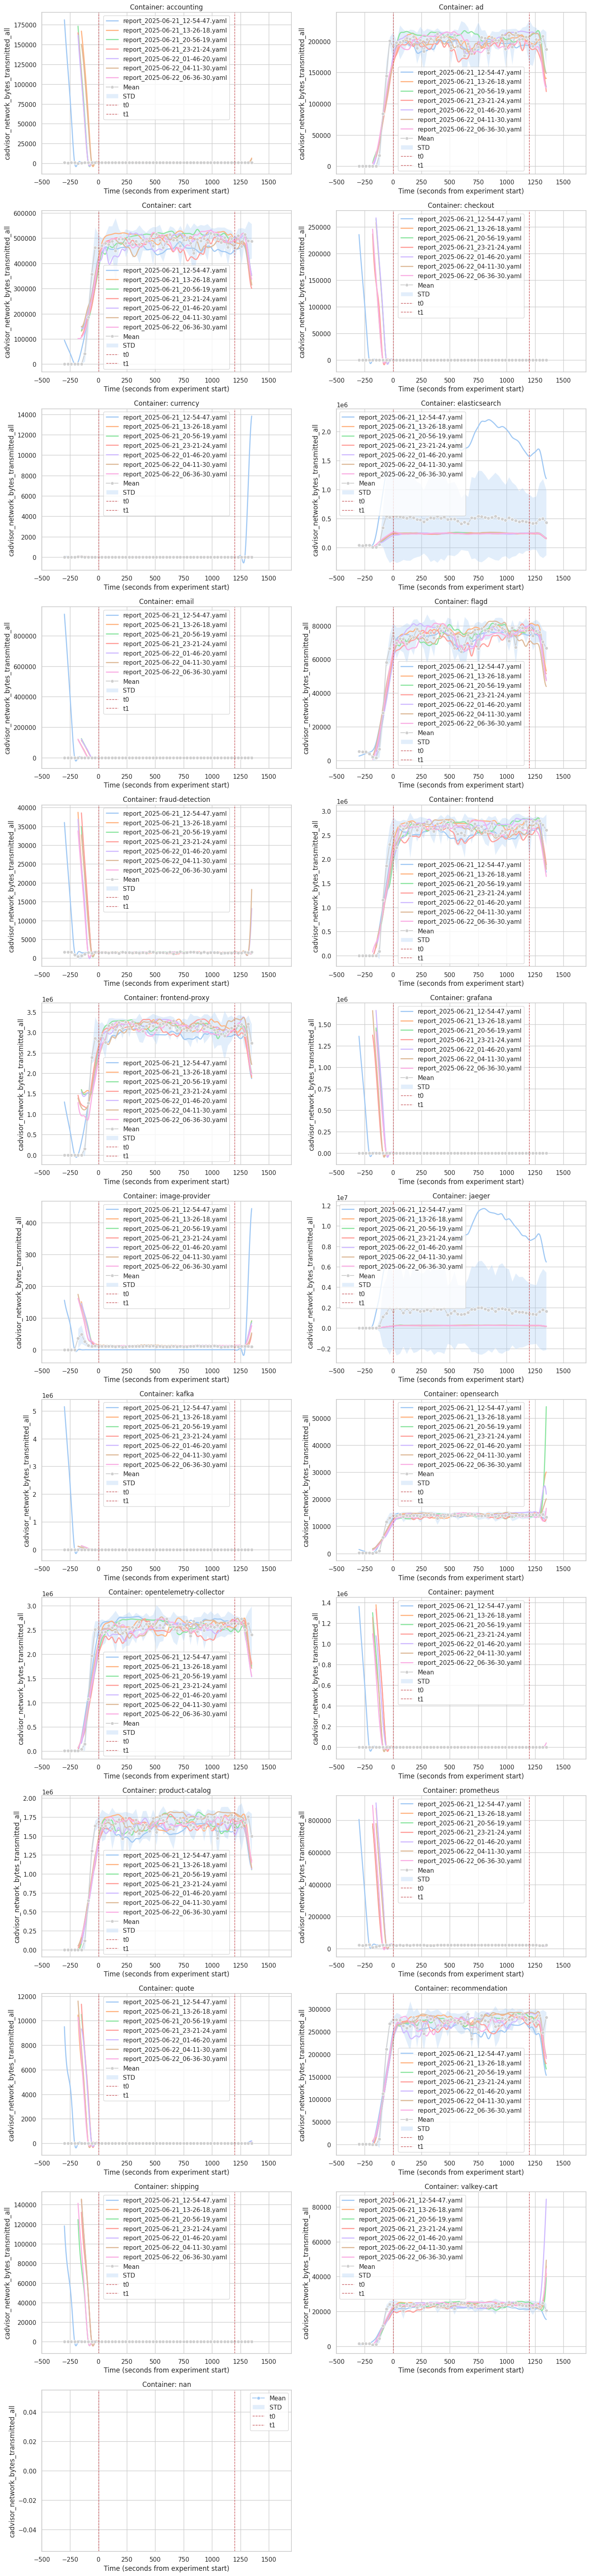

In [ ]:


baseline_experiment_list = []

# iterate over all reports and find a string in them
print("Searching for most recent experiments in list of reports " + len(yaml_files).__str__())
for file in yaml_files:
    report_path = path.join("reports", file)
    # read the file as a string
    with open(report_path, "r") as f:
        content = f.read()
        if "recommendation_k8_base_1m_otel.yml" in content:
            baseline_experiment_list.append(file)

print("Found " + len(baseline_experiment_list).__str__() + " baseline experiments")


report_names = baseline_experiment_list

REPORT_LABELS = {}

for report in report_names:
    REPORT_LABELS[report] = report


#REPORT_LABELS = {report_names[0]: "Baseline", report_names[1]: "Delay 1m", report_names[2]: "1s delay", report_names[3]: "5% Base", report_names[4]: "5% Delay", report_names[5]: "10% Base", report_names[6]: "10% Delay",  report_names[7]: "50% Base", report_names[8]: "1s"}

response_name = "cadvisor_network_bytes_transmitted_all"

cached_baseline_network_received_pods, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_baseline_network_received_pods, report_directory, response_name, treatment_names, report_names)

#plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time)

plot_individual_and_aggregated(combined_df, response_name, treatment_end_time, treatment_start_time)



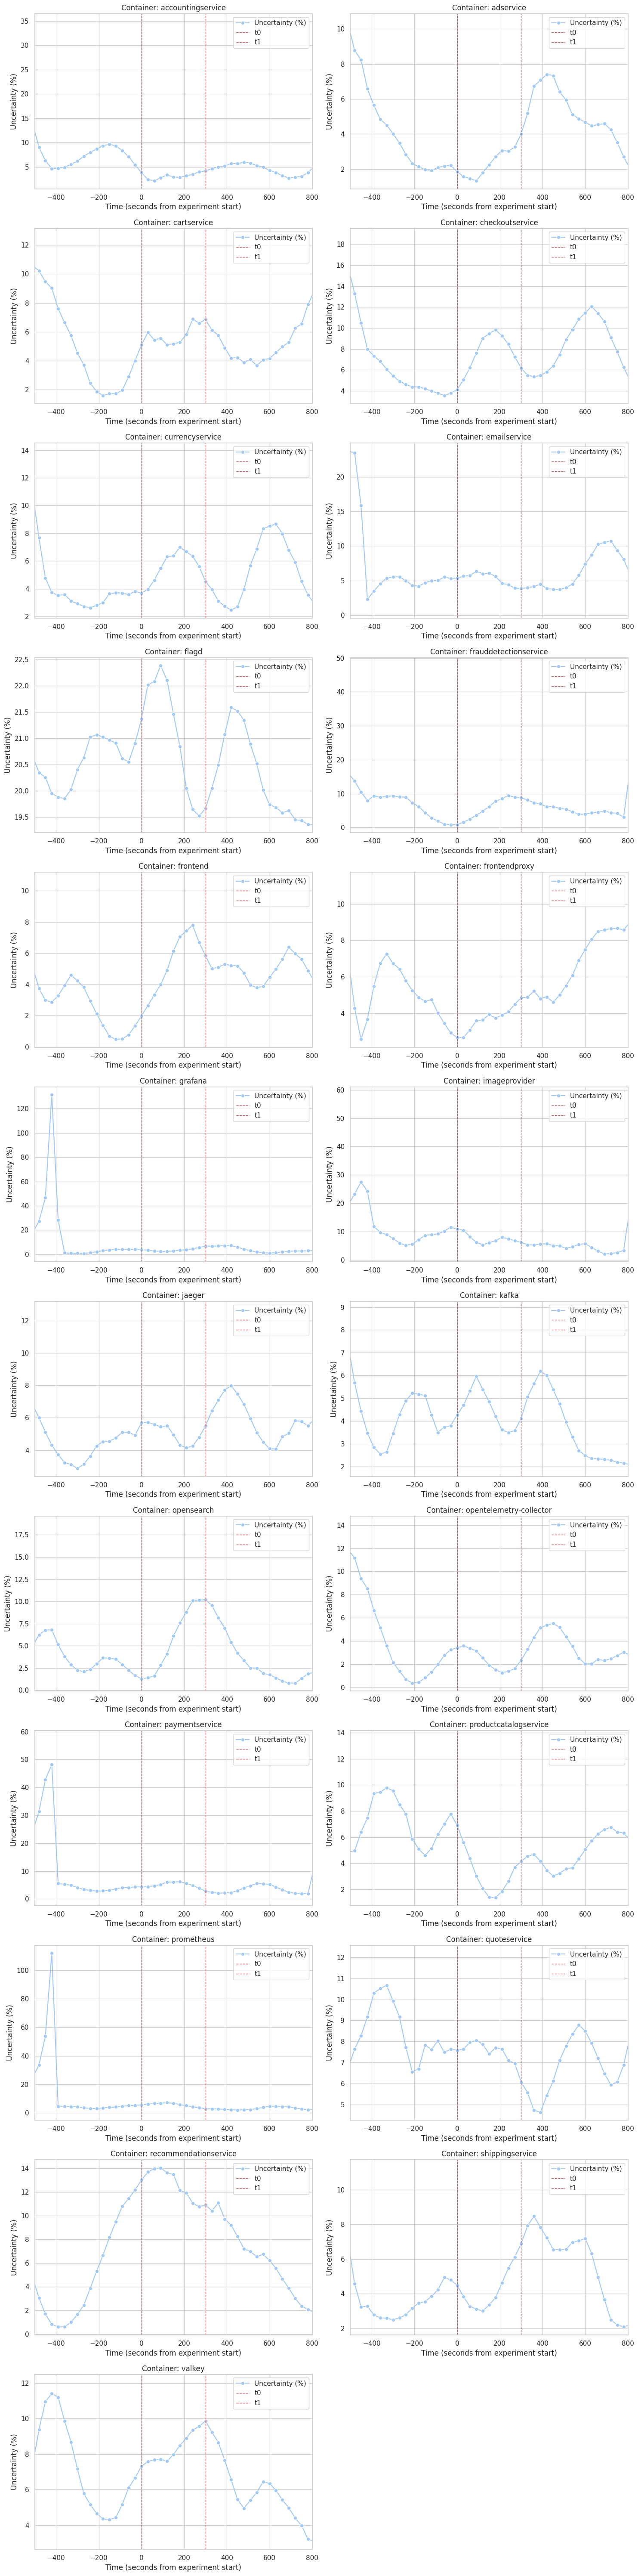

In [ ]:
plot_percentage_uncertainty(combined_df, response_name, treatment_end_time, treatment_start_time)

In [ ]:
def mean_of_experiments_of_type(dataframes, response_name, container_key='label_app_kubernetes_io_name'):
    """     print(dataframes)
        #print(dataframes.columns) AttributeError: 'list' object has no attribute 'columns'
        print(dataframes[0])
        print(dataframes[0].columns)
        for df in dataframes:
            combined_df = pd.concat(dataframes, ignore_index=True)
        print(combined_df)
        
    """
    # Compute aggregated statistics by rounding experiment_seconds
    dataframes['rounded_experiment_seconds'] = dataframes['experiment_seconds'].round(0)
    agg_df = (
        combined_df
        .groupby([container_key, 'rounded_experiment_seconds'])[response_name]
        .agg(['mean', 'std'])
        .reset_index()
    )
    return agg_df

def plot_sum_aggregated_all_containers(combined_df, response_name, treatment_end_time, treatment_start_time, report_name_key="report_name", time_key="rounded_experiment_seconds", interpolation_kind="cubic"):
    """
    Plots a single graph that aggregates (sums up) data across all containers for each report name.
    
    Parameters:
        combined_df (DataFrame): The DataFrame containing experiment data.
        response_name (str): Column name for the y-axis (e.g. metric to plot).
        treatment_end_time (datetime): End time of the treatment.
        treatment_start_time (datetime): Start time of the treatment.
        report_name_key (str): Column name representing report names (default "report_name").
        time_key (str): Column name representing time (default "rounded_experiment_seconds").
        interpolation_kind (str): Interpolation method to use (default "cubic").
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy.interpolate import interp1d

    # Normalize treatment times (t0 is set to 0)
    treatment_start_seconds = 0  
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    # Aggregate the data across containers for each report by summing the response metric
    aggregated_df = combined_df.groupby([report_name_key, time_key])[response_name].sum().reset_index()
    
    # Set the seaborn style and palette for consistency
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    plt.figure(figsize=(15, 7))
    
    # Loop through each report name and plot the aggregated treatment curve
    for report in aggregated_df[report_name_key].unique():
        df = aggregated_df[aggregated_df[report_name_key] == report].sort_values(by=time_key)
        if len(df) > 1:
            # Interpolate the aggregated response for a smoother curve
            f = interp1d(df[time_key], df[response_name], kind=interpolation_kind)
            time_new = np.linspace(df[time_key].min(), df[time_key].max(), num=500)
            response_interpolated = f(time_new)
            sns.lineplot(x=time_new, y=response_interpolated, label=report, linewidth=2)
        else:
            print(f"Only one data point for report '{report}'.")
    
    # Add vertical lines for treatment start (t0) and end (t1)
    plt.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    plt.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")
    
    plt.title("Aggregated Sum of All Containers by Report Name")
    plt.xlabel("Time (seconds from experiment start)")
    plt.ylabel(response_name)
    plt.xlim(-500, treatment_end_seconds + 500)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_percentage_difference_all_containers(combined_df, response_name, treatment_end_time, treatment_start_time, time_key="rounded_experiment_seconds"):
    """
    Plots a single graph of the average percentage uncertainty (calculated as (std/mean)*100)
    across all containers at each time point.
    
    The function first computes the uncertainty percentage for each row and then groups 
    the data by the time key to average these percentages.
    
    Parameters:
        combined_df (DataFrame): The DataFrame containing experiment data.
        response_name (str): Column name of the metric (for clarity; the calculation uses 'mean' and 'std').
        treatment_end_time (datetime): End time of the treatment.
        treatment_start_time (datetime): Start time of the treatment.
        time_key (str): Column name representing time (default "rounded_experiment_seconds").
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Normalize treatment times (t0 is set to 0)
    treatment_start_seconds = 0  
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    # Compute percentage uncertainty for each row
    df = combined_df.copy()
    df['uncertainty_pct'] = np.where(
        df['mean'] != 0,
        (df['std'] / df['mean']) * 100,
        0
    )
    
    # Aggregate by taking the average uncertainty percentage across containers for each time point
    agg_df = df.groupby(time_key)['uncertainty_pct'].mean().reset_index()
    
    # Set the seaborn style and palette for consistency
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    # Create the single plot
    plt.figure(figsize=(15, 7))
    sns.lineplot(
        x=time_key,
        y='uncertainty_pct',
        data=agg_df,
        marker='o',
        label='Average Uncertainty (%)'
    )
    
    # Add vertical lines for treatment start (t0) and end (t1)
    plt.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    plt.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")
    
    plt.title("Aggregated Average Percentage Uncertainty Across All Containers")
    plt.xlabel("Time (seconds from experiment start)")
    plt.ylabel("Average Uncertainty (%)")
    plt.xlim(-500, treatment_end_seconds + 500)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_percentage_difference_mean(combined_condensed_df, treatment_end_time, treatment_start_time):
      
    # Normalize treatment times (t0 is set to 0)
    treatment_start_seconds = 0  
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    # Get the baseline data
    baseline_df = combined_condensed_df[combined_condensed_df["report_name"] == "recommendation_k8_base_1m_otel"]

    # Merge the baseline data with the other treatments
    baseline_df = baseline_df.rename(columns={"mean": "baseline"})
    merged_df = pd.merge(combined_condensed_df, baseline_df[["rounded_experiment_seconds", "baseline"]], on="rounded_experiment_seconds")

    # Calculate the percentage difference for each treatment relative to the baseline
    merged_df["percentage_difference"] = (merged_df["mean"] - merged_df["baseline"]) / merged_df["baseline"] * 100

    # Plot the percentage difference for each treatment
    plt.figure(figsize=(15, 7))
    sns.lineplot(
        x="rounded_experiment_seconds",
        y="percentage_difference",
        hue="report_name",
        data=merged_df,
        marker='o'
    )
    plt.axhline(y=0, color="r", linestyle="--")

    # Add vertical lines for treatment start (t0) and end (t1)
    plt.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    plt.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

    plt.title("Percentage Difference from Baseline for All Treatments")
    plt.xlabel("Time (seconds from experiment start)")
    plt.ylabel("Percentage Difference (%)")
    # only show the range from 0 - 20
    plt.ylim(-20, 150)
    plt.grid(True)
    plt.legend(title="Treatment")
    plt.tight_layout()
    plt.show()

In [ ]:
experiment_report_cache = {}

Found 7 recommendation_k8_base_1m_otel experiments
Loading dataframes from reports because cached dataframes are empty.
[Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTr

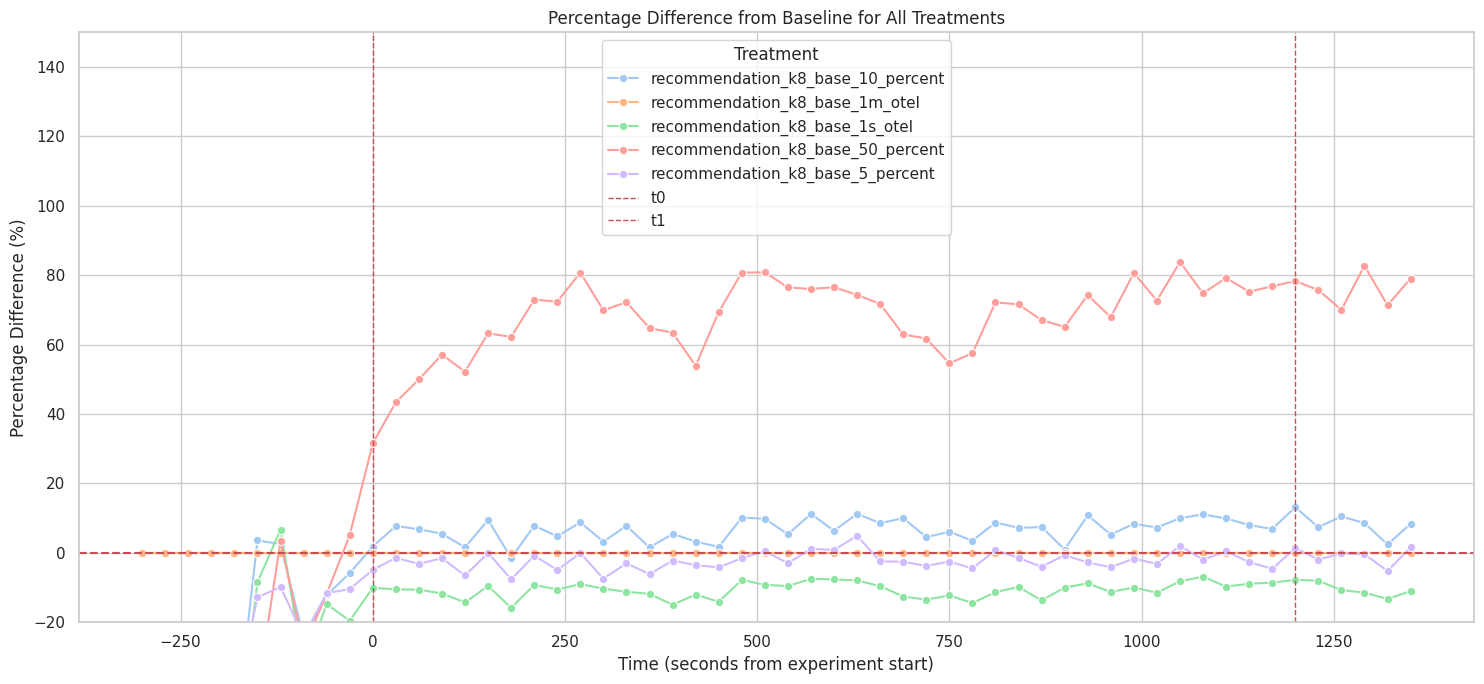

In [ ]:


response_name = "cadvisor_network_bytes_transmitted_all"




experiments_map = {
    "recommendation_k8_base_1m_otel": [],
    "recommendation_k8_base_1s_otel": [],
    "recommendation_k8_base_5_percent": [],
    "recommendation_k8_base_10_percent": [],
    "recommendation_k8_base_50_percent": [],
}

mean_combined_df = {}


for experiment in experiments_map.keys():
    for file in yaml_files:
        report_path = path.join("reports", file)
        # read the file as a string
        with open(report_path, "r") as f:
            content = f.read()
            if f"{experiment}.yml" in content:
                if not experiments_map[experiment]:
                    experiments_map[experiment] = []

                experiments_map[experiment].append(file)


    print("Found " + len(experiments_map[experiment]).__str__() + " " + experiment + " experiments")


    report_names = experiments_map[experiment]

    REPORT_LABELS = {}

    for report in report_names:
        REPORT_LABELS[report] = report


    if not experiment in experiment_report_cache:
        experiment_report_cache[experiment] = None



    experiment_report_cache[experiment], combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(experiment_report_cache[experiment], report_directory, response_name, treatment_names, report_names)


    mean_combined_df[experiment] = mean_of_experiments_of_type(combined_df, response_name)

    # replace the report name with the experiment name
    mean_combined_df[experiment]['report_name'] = experiment


#plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time)

combined_df = pd.concat(mean_combined_df.values(), ignore_index=True)
print(combined_df)

combined_df["experiment_seconds"] = combined_df["rounded_experiment_seconds"]



combined_condensed_df = combined_df.groupby(["report_name", "rounded_experiment_seconds"])["mean"].sum().reset_index()


plot_percentage_difference_mean(combined_condensed_df, treatment_end_time, treatment_start_time)


## Pre-Processing for Meta-Notebook

In [12]:
def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        #print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        print(f"Found {len(selected_interactions)} interactions for {report_name} and {treatment_name}.")
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None     
    
    
def load_reports_and_normalize_time(cached_dataframes, report_directory, response_name, treatment_names, report_names):
    response_dataframes = cached_dataframes or []
    # Load the interactions if not already loaded
    if not response_dataframes or len(response_dataframes) == 0:
        print(f"Loading dataframes from reports because cached dataframes are empty.")
        for report_name in report_names:
            for treatment_name in treatment_names:
                interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
                if interaction:
                    #print(interaction)
                    #print(interaction.response_data)
                    # Add columns to identify the treatment and report
                    interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                    interaction.response_data["treatment_start"] = interaction.treatment_start
                    interaction.response_data["treatment_end"] = interaction.treatment_end
                    interaction.response_data["report"] = report_name
                    interaction.response_data["label"] = f"{REPORT_LABELS[report_name]}"
                    response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    else:
        print("Using cached dataframes.")
    cached_dataframes = response_dataframes

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        assert isinstance(response_dataframes, list)

        for df in response_dataframes:
            assert isinstance(df, pd.DataFrame)
            # Convert index to datetime if needed and ensure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Ensure both are timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Calculate the interval between data points in seconds
            time_interval = (df.index[1] - df.index[0]).total_seconds()

            # Add the experiment_seconds column
            df = df.copy()  # Work with a copy to avoid modifying a view
            df.loc[:, "experiment_seconds"] = (df.index - current_treatment_start).total_seconds()
            df.loc[:, "time_normalized"] = df["experiment_seconds"]

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)
    else:
        print("No valid interactions found for the specified treatment names.")


    # Combine all the normalized dataframes
    combined_df = pd.concat(normalized_dataframes)
    return cached_dataframes, combined_df, treatment_start_time, treatment_end_time


cached_baseline_50_percent_dataframes_kepler_pods = []


cached_baseline_50_percent_dataframes_kepler_pods, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_baseline_50_percent_dataframes_kepler_pods, report_directory, "cadvisor_network_bytes_received_all_absolute", ["empty_treatment"], report_names)

print(combined_df)



# Drop timestamp index if needed
df = combined_df.reset_index(drop=True)

# Round the normalized time (e.g., to nearest second)
df["time_normalized_rounded"] = df["time_normalized"].round(0)

# Select necessary columns
columns_to_keep = [
    "time_normalized_rounded", "report", "label",
    "label_app_kubernetes_io_name", "namespace", "cadvisor_network_bytes_received_all_absolute", "component"
]
df_clean = df[columns_to_keep]

# Pivot: rows = report + label + time, columns = container/namespace
pivot_df = df_clean.pivot_table(
    index=["report", "label", "time_normalized_rounded"],
    columns=["label_app_kubernetes_io_name", "namespace", "component"],
    values="cadvisor_network_bytes_received_all_absolute",
    aggfunc="mean"
)

# Flatten column headers
pivot_df.columns = [f"{components}_{namespace}" for name, namespace, components in pivot_df.columns]

# Sort for readability
pivot_df = pivot_df.sort_index()

# Drop rows where time < 0 or > 3600
pivot_df = pivot_df[pivot_df.index.get_level_values("time_normalized_rounded") >= 0]
pivot_df = pivot_df[pivot_df.index.get_level_values("time_normalized_rounded") <= 3600]

# Subtract the first value (at time = 0) for each (report, label)
def subtract_first(df_group):
    first_row = df_group.loc[df_group.index.get_level_values("time_normalized_rounded") == 0]
    if not first_row.empty:
        return df_group - first_row.values[0]
    else:
        return df_group  # nothing to subtract if no t=0

pivot_df = pivot_df.groupby(["report", "label"], group_keys=False).apply(subtract_first)


# Save to CSV
pivot_df.to_csv("cadvisor_network_bytes_received_all_absolute_bytes.csv")



Loading dataframes from reports because cached dataframes are empty.
Found 1 interactions for report_2025-07-16_22-01-34.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_01-45-27.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_03-00-32.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_04-15-12.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_05-30-26.yaml and empty_treatment.
Found 1 interactions for report_2025-07-16_23-16-11.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_00-30-49.yaml and empty_treatment.
                                component label_app_kubernetes_io_name  \
timestamp                                                                
2025-07-16 20:01:12.437999964  accounting                   accounting   
2025-07-16 20:01:42.437999964  accounting                   accounting   
2025-07-16 20:02:12.437999964  accounting                   accounting   
2025-07-16 20:0

In [13]:
def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        #print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        print(f"Found {len(selected_interactions)} interactions for {report_name} and {treatment_name}.")
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None     
    
    
def load_reports_and_normalize_time(cached_dataframes, report_directory, response_name, treatment_names, report_names):
    response_dataframes = cached_dataframes or []
    # Load the interactions if not already loaded
    if not response_dataframes or len(response_dataframes) == 0:
        print(f"Loading dataframes from reports because cached dataframes are empty.")
        for report_name in report_names:
            for treatment_name in treatment_names:
                interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
                if interaction:
                    #print(interaction)
                    #print(interaction.response_data)
                    # Add columns to identify the treatment and report
                    interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                    interaction.response_data["treatment_start"] = interaction.treatment_start
                    interaction.response_data["treatment_end"] = interaction.treatment_end
                    interaction.response_data["report"] = report_name
                    interaction.response_data["label"] = f"{REPORT_LABELS[report_name]}"
                    response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    else:
        print("Using cached dataframes.")
    cached_dataframes = response_dataframes

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        assert isinstance(response_dataframes, list)

        for df in response_dataframes:
            assert isinstance(df, pd.DataFrame)
            # Convert index to datetime if needed and ensure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Ensure both are timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Calculate the interval between data points in seconds
            time_interval = (df.index[1] - df.index[0]).total_seconds()

            # Add the experiment_seconds column
            df = df.copy()  # Work with a copy to avoid modifying a view
            df.loc[:, "experiment_seconds"] = (df.index - current_treatment_start).total_seconds()
            df.loc[:, "time_normalized"] = df["experiment_seconds"]

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)
    else:
        print("No valid interactions found for the specified treatment names.")


    # Combine all the normalized dataframes
    combined_df = pd.concat(normalized_dataframes)
    return cached_dataframes, combined_df, treatment_start_time, treatment_end_time


cached_baseline_50_percent_dataframes_kepler_pods = []


cached_baseline_50_percent_dataframes_kepler_pods, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_baseline_50_percent_dataframes_kepler_pods, report_directory, "cadvisor_network_bytes_transmitted_all_absolute", ["empty_treatment"], report_names)

print(combined_df)



# Drop timestamp index if needed
df = combined_df.reset_index(drop=True)

# Round the normalized time (e.g., to nearest second)
df["time_normalized_rounded"] = df["time_normalized"].round(0)

# Select necessary columns
columns_to_keep = [
    "time_normalized_rounded", "report", "label",
    "label_app_kubernetes_io_name", "namespace", "cadvisor_network_bytes_transmitted_all_absolute", "component"
]
df_clean = df[columns_to_keep]

# Pivot: rows = report + label + time, columns = container/namespace
pivot_df = df_clean.pivot_table(
    index=["report", "label", "time_normalized_rounded"],
    columns=["label_app_kubernetes_io_name", "namespace", "component"],
    values="cadvisor_network_bytes_transmitted_all_absolute",
    aggfunc="mean"
)

# Flatten column headers
pivot_df.columns = [f"{components}_{namespace}" for name, namespace, components in pivot_df.columns]
#pivot_df.columns = [f"{name}_{namespace}" for name, namespace in pivot_df.columns]

# Sort for readability
pivot_df = pivot_df.sort_index()

# Drop rows where time < 0 or > 3600
pivot_df = pivot_df[pivot_df.index.get_level_values("time_normalized_rounded") >= 0]
pivot_df = pivot_df[pivot_df.index.get_level_values("time_normalized_rounded") <= 3600]

# Subtract the first value (at time = 0) for each (report, label)
def subtract_first(df_group):
    first_row = df_group.loc[df_group.index.get_level_values("time_normalized_rounded") == 0]
    if not first_row.empty:
        return df_group - first_row.values[0]
    else:
        return df_group  # nothing to subtract if no t=0

pivot_df = pivot_df.groupby(["report", "label"], group_keys=False).apply(subtract_first)


# Save to CSV
pivot_df.to_csv("cadvisor_network_bytes_transmitted_all_absolute_bytes.csv")



Loading dataframes from reports because cached dataframes are empty.
Found 1 interactions for report_2025-07-16_22-01-34.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_01-45-27.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_03-00-32.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_04-15-12.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_05-30-26.yaml and empty_treatment.
Found 1 interactions for report_2025-07-16_23-16-11.yaml and empty_treatment.
Found 1 interactions for report_2025-07-17_00-30-49.yaml and empty_treatment.
                                component label_app_kubernetes_io_name  \
timestamp                                                                
2025-07-16 20:01:12.437999964  accounting                   accounting   
2025-07-16 20:01:42.437999964  accounting                   accounting   
2025-07-16 20:02:12.437999964  accounting                   accounting   
2025-07-16 20:0